# 0.0. Imports

In [238]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [239]:
from datetime import datetime

import inflection
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image

from matplotlib import pyplot as plt

from scipy import stats as ss

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier

import utils

## 0.1. Helper Functions and Configurations

In [240]:
SEED = 42
NUMERICAL_DROP = ['row_number', 'exited']
CATEGORICAL_DROP = ['surname']
PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img")

plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set(rc={'figure.figsize': (25, 12)})

os.makedirs(IMAGES_PATH, exist_ok=True)

In [241]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution);

In [242]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1))) 

In [243]:
def unite_features_target(features, target):
    return pd.concat([features, target], axis = 1)

In [244]:
def split_features_target(dataframe):
    X_train = dataframe.drop(['exited'], axis = 1)
    y_train = dataframe.loc[:, 'exited']
    
    return X_train, y_train

In [245]:
def show_dataframe_dimensions(dataframe):
    print(f"Number of Rows: {dataframe.shape[0]}")
    print(f"Number of Columns: {dataframe.shape[1]}")
    
    return None

In [246]:
def get_numerical_attributes(dataframe):
    return dataframe.select_dtypes(include=['int64', 'float64']).drop(NUMERICAL_DROP, axis=1)

In [247]:
def get_categorical_attributes(dataframe):
    return dataframe.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(CATEGORICAL_DROP, axis=1)

In [248]:
def get_first_order_statistics(dataframe):
    # Central Tendency Metrics
    mean = pd.DataFrame(dataframe.apply(np.mean)).T
    median = pd.DataFrame(dataframe.apply(np.median)).T

    # Dispersion Metrics
    min_ = pd.DataFrame(dataframe.apply(min)).T
    max_ = pd.DataFrame(dataframe.apply(max)).T
    range_ = pd.DataFrame(dataframe.apply(lambda x: x.max() - x.min())).T
    std = pd.DataFrame(dataframe.apply(np.std)).T
    skew = pd.DataFrame(dataframe.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(dataframe.apply(lambda x: x.kurtosis())).T

    # Metrics Concatenation
    m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    display(m)
    
    return None

## 0.2. Load Data

In [13]:
df_raw = pd.read_csv('../data/training/abandono_clientes.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 0.3. Data Split

In [14]:
# Sorting Data and Terget
target = df_raw.Exited
data = df_raw.drop('Exited', axis=1)

# Spliting Data
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.80, test_size=0.20, random_state=SEED, stratify=target)

print(f'Train Size: {X_train.shape[0]} ({(X_train.shape[0]/df_raw.shape[0])*100}%)')
print(f'Train Size: {X_test.shape[0]} ({(X_test.shape[0]/df_raw.shape[0])*100}%)')

Train Size: 8000 (80.0%)
Train Size: 2000 (20.0%)


# 1.0. Data Description

In [15]:
# Unite the test and train data to create the dataframe
df1 = unite_features_target(X_train, y_train)
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2151,2152,15588614,Walton,753,France,Male,57,7,0.00,1,1,0,159475.08,1
8392,8393,15641158,Belcher,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
5006,5007,15750014,Chikere,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
4117,4118,15663964,Pagnotto,561,France,Male,37,5,0.00,2,1,0,83093.25,0
7182,7183,15573520,Rhodes,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


## 1.1. Columns Description

| Column | Description |
| :----- | :---------- |
| `RowNumber` | Row ID |
| `CustomerId` | Customer ID |
| `Surname` | Customer's Last name |
| `CreditScore` | Customer Credit Score |
| `Geography` | Customer's Country of Residence |
| `Gender` | Costumer Gender |
| `Age` | Costumer Age |
| `Tenure` | Quantity of years that customer is a institution client |
| `Balande` | How much money the client have on it's account |
| `NumOfProducts` | Quantity of products that the client had purchased with the institution |
| `HasCrCard` | Indicates if the client has a credit card or not with the institution. 1 - client has credit card; 0 - client dosen't have credit card |
| `IsActiveMember` | Indicates if the client is active or not. 1 - active client; 0 - non active client |
| `EstimatedSalary` | Client's estimated anual salary |
| `Exited` | Indicates whether the client has an account at the institution. 1 - Client has exited instittion; 0 - client dosen't have exited institution |

## 1.2. Rename Columns

In [16]:
# Class responsible for renaming columns. 
# It is inside utils directory
class RenameDataframeColumns_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.rename_columns(X)
        
        return X
    
    def rename_columns(self, dataframe):
        # Copy DataFrame
        df = dataframe.copy()
        
        # Columns Names
        cols_old = list(df.columns)

        # Function to convert columns names to snake_case pattern
        snakecase = lambda x: inflection.underscore(x)

        # New columns names
        cols_new = list(map(snakecase, cols_old))

        # Apply new columns names to DataFrame
        df.columns = cols_new
        
        return df

In [17]:
# Create Pipeline to rename DataFrame
rename_pipe = Pipeline([
    ('rename', utils.RenameDataframeColumns())
])

# Use Pipeline to rename DataFrame Columns
df1 = rename_pipe.fit_transform(df1)
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2151,2152,15588614,Walton,753,France,Male,57,7,0.00,1,1,0,159475.08,1
8392,8393,15641158,Belcher,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
5006,5007,15750014,Chikere,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
4117,4118,15663964,Pagnotto,561,France,Male,37,5,0.00,2,1,0,83093.25,0
7182,7183,15573520,Rhodes,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


## 1.3. Data Dimensions

In [18]:
show_dataframe_dimensions(df1)

Number of Rows: 8000
Number of Columns: 14


## 1.4. Data Types

In [19]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5. Check NA

In [20]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.6. Fill out NAs

There's no need to fill NA in this data set

## 1.7. Change Data Types

There's no need to change data types

## 1.8. Descriptive Statistics

### 1.8.1. Numeric and Categoric Separation

In [21]:
# Filter only numerical attibutes
num_attributes = get_numerical_attributes(df1)

# Filter only categorical attibutes
cat_attributes = get_categorical_attributes(df1)

#### 1.8.1.1. Numericas Attributes

In [22]:
# Create first order statistical analysis for numerical data
get_first_order_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,15565701.00,15815690.00,249989.00,1.569088e+07,1.568995e+07,71931.689685,0.006936,-1.196055
1,credit_score,350.00,850.00,500.00,6.507525e+02,6.520000e+02,96.590394,-0.079540,-0.418624
2,age,18.00,92.00,74.00,3.894662e+01,3.700000e+01,10.526219,1.035706,1.459448
3,tenure,0.00,10.00,10.00,5.016625e+00,5.000000e+00,2.896610,0.013124,-1.172842
4,balance,0.00,238387.56,238387.56,7.638121e+04,9.705515e+04,62298.159597,-0.141721,-1.492209
5,num_of_products,1.00,4.00,3.00,1.529500e+00,1.000000e+00,0.581704,0.755984,0.636943
6,has_cr_card,0.00,1.00,1.00,7.087500e-01,1.000000e+00,0.454338,-0.919091,-1.155561
7,is_active_member,0.00,1.00,1.00,5.148750e-01,1.000000e+00,0.499779,-0.059538,-1.996955
8,estimated_salary,11.58,199992.48,199980.90,9.973081e+04,9.944694e+04,57331.532983,0.007126,-1.174789


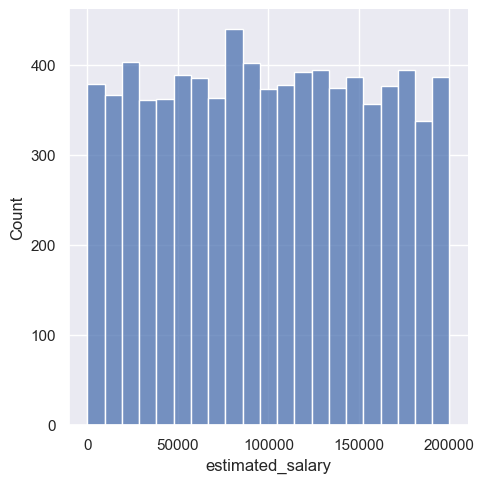

In [23]:
# Check estimated_salary attribute distribution
sns.displot( df1['estimated_salary'], kde=False );

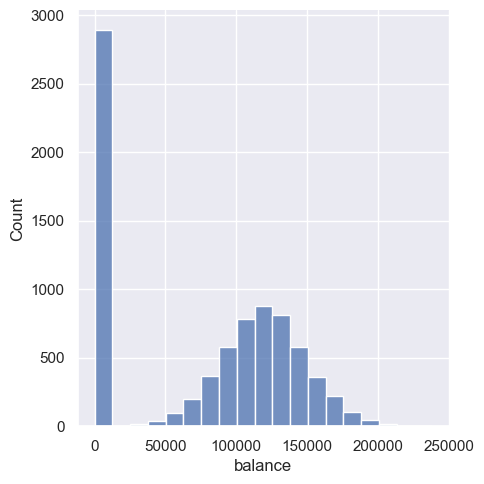

In [24]:
# Check balance attribute distribution
sns.displot( df1['balance'], kde=False );

##### 1.8.1.1.1. Numerical Attributes Analysis

* `Balance`: About 25% of the observations have value iqual to zero. Need to be investigated
* `estimated_salary`: The graph shows that the distribuition partially uniform. Need to be investigated.

Both attributes need to investigated in in the next iterations.

The other attributes will be checked in the next setions

#### 1.8.1.2. Categorical Attributes

In [25]:
# Check categorical attributes unique values
cat_attributes.apply(lambda x: x.unique().shape[0])

geography    3
gender       2
dtype: int64

Saving figure categorical_analysis_geography


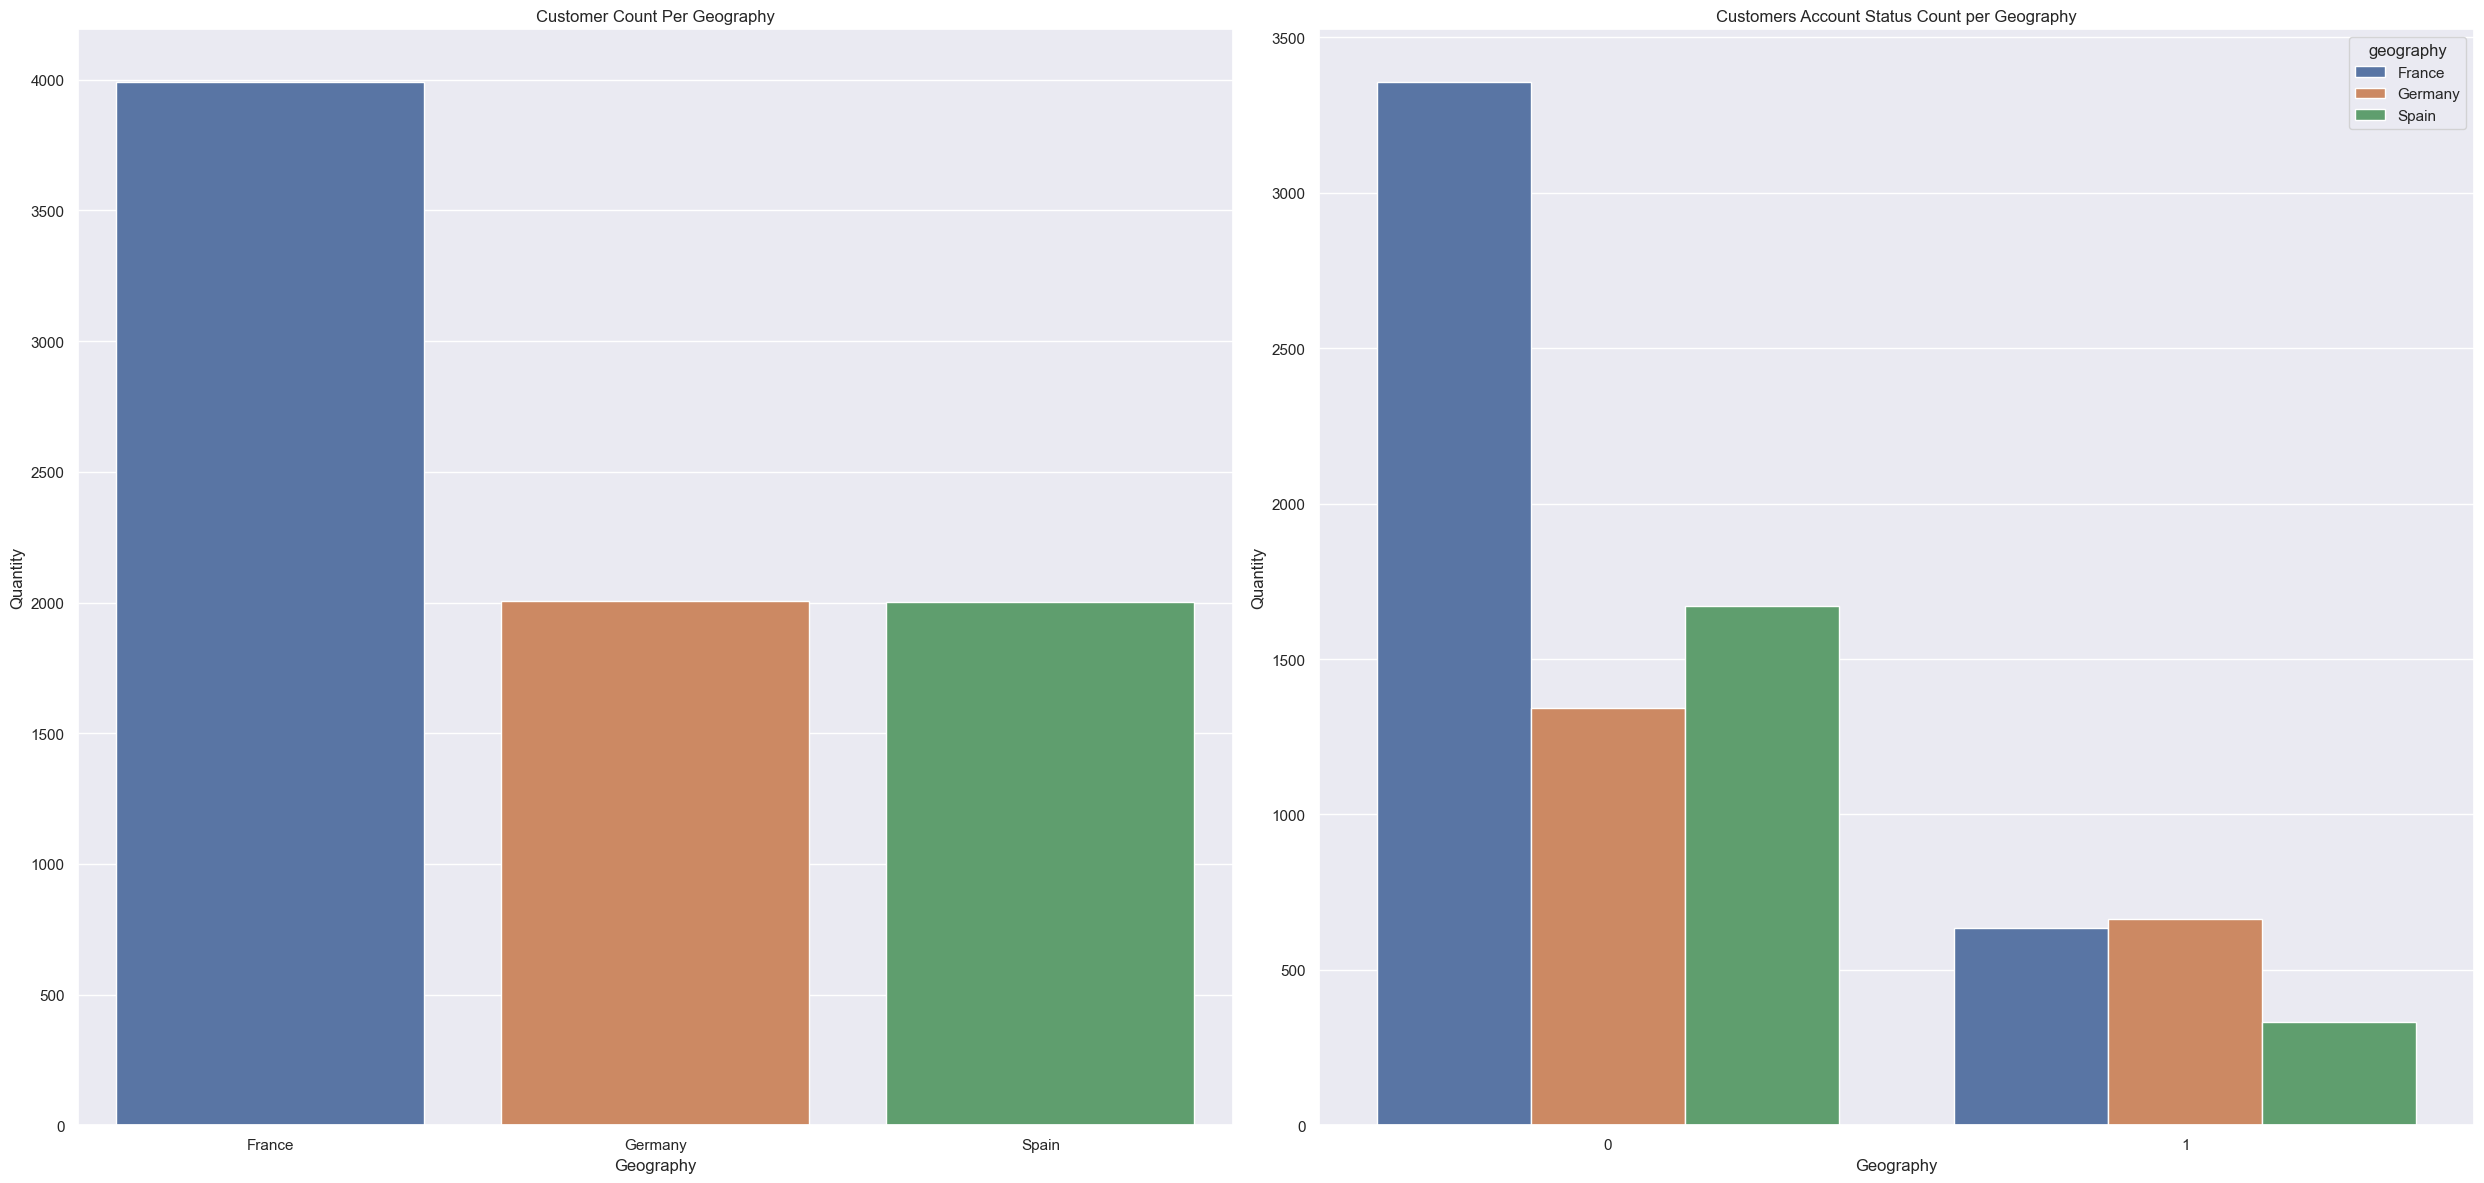

In [253]:
# Group clients by their geography attribute and count them
geography = df1.loc[ :, ['row_number', 'geography'] ].groupby(['geography']).count().reset_index()

# Group clients by their geography and exited attributes and count them
ext_geography = df1.loc[ :, ['row_number', 'exited', 'geography'] ].groupby(['exited', 'geography']).count().reset_index()

# Create a plot to show how many customer for each geography exists
# in the dataset
plt.subplot(1, 2, 1)
ax = sns.barplot(x='geography', y='row_number', data=geography)
ax.set(title='Customer Count Per Geography', xlabel='Geography', ylabel='Quantity');

# Create a plot to show how many customer for each geography that left
# and remained in the bank exists in the dataset
plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_geography, hue='geography');
ax.set(title='Customers Account Status Count per Geography', xlabel='Geography', ylabel='Quantity');
save_fig('categorical_analysis_geography')

Saving figure categorical_analysis_gender


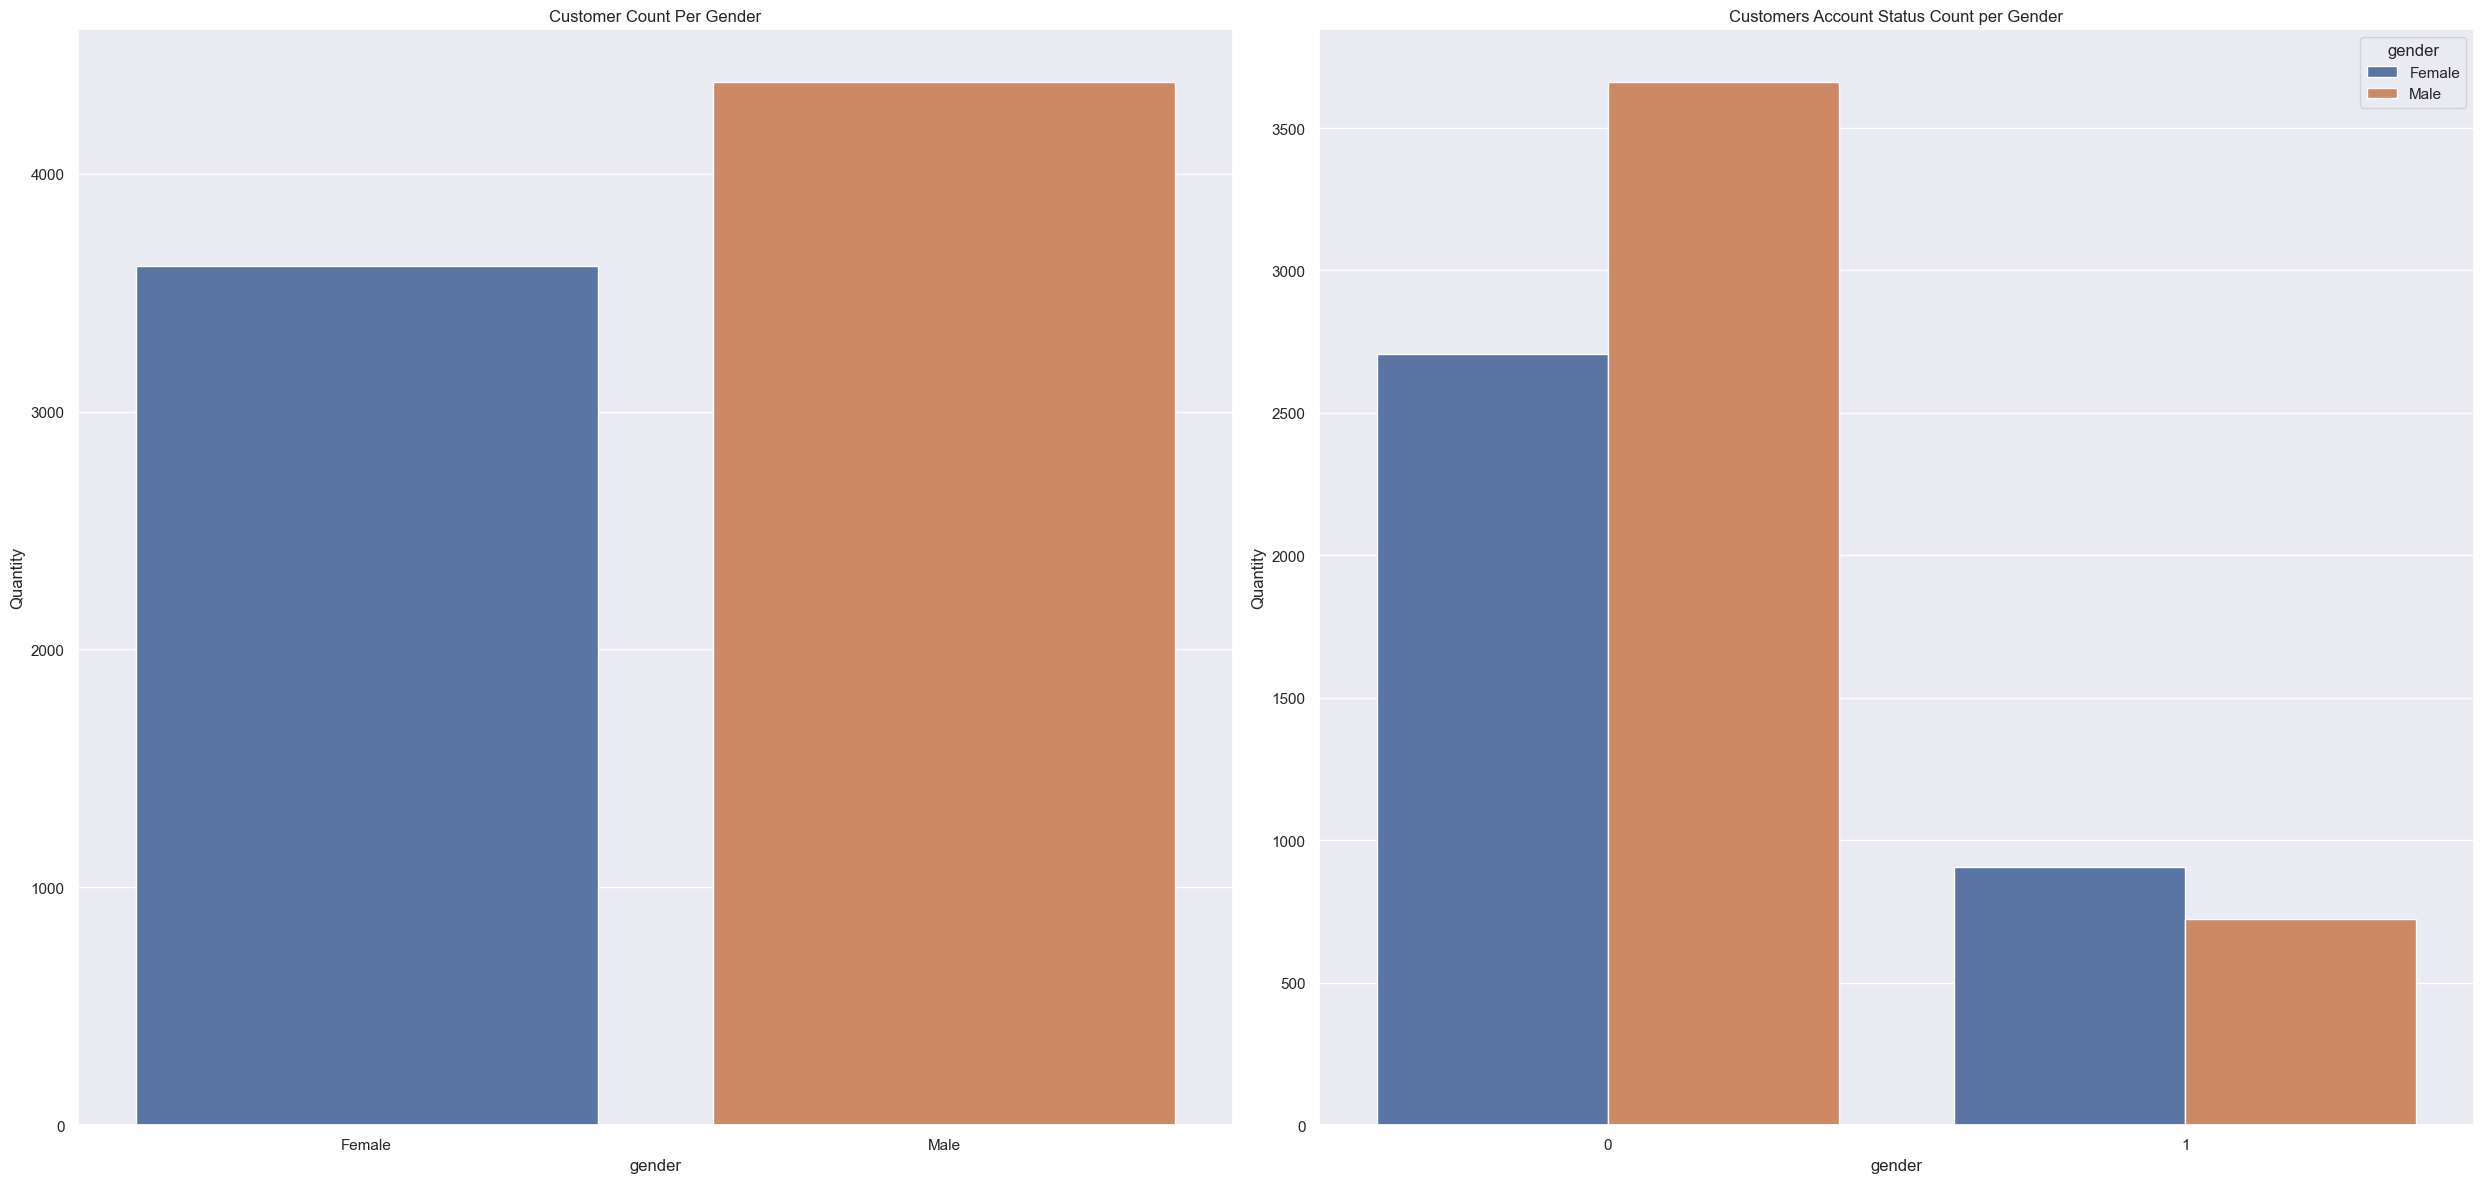

In [254]:
# # Group clients by their gender attribute and count them
gender = df1.loc[ :, ['row_number', 'gender'] ].groupby(['gender']).count().reset_index()

# Group clients by their gender and exited attributes and count them
ext_gender = df1.loc[ :, ['row_number', 'exited', 'gender'] ].groupby(['exited', 'gender']).count().reset_index()

# Create a plot to show how many customer for each gender exists
# in the dataset
plt.subplot(1, 2, 1)
ax = sns.barplot(x='gender', y='row_number', data=gender)
ax.set(title='Customer Count Per Gender', xlabel='gender', ylabel='Quantity');

# Create a plot to show how many customer for each gender left and remained 
# in the bank as a customer exists in the dataset
plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_gender, hue='gender');
ax.set(title='Customers Account Status Count per Gender', xlabel='gender', ylabel='Quantity');
save_fig('categorical_analysis_gender')

##### 1.8.1.2.1. Categorical Attributes Analysis

* Most customers are men, but the customers who most left the bank the most are women
* Most customers are from France, but the customers who left the bank the most are from Germany

# 2.0. Feature Engineering

In [28]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

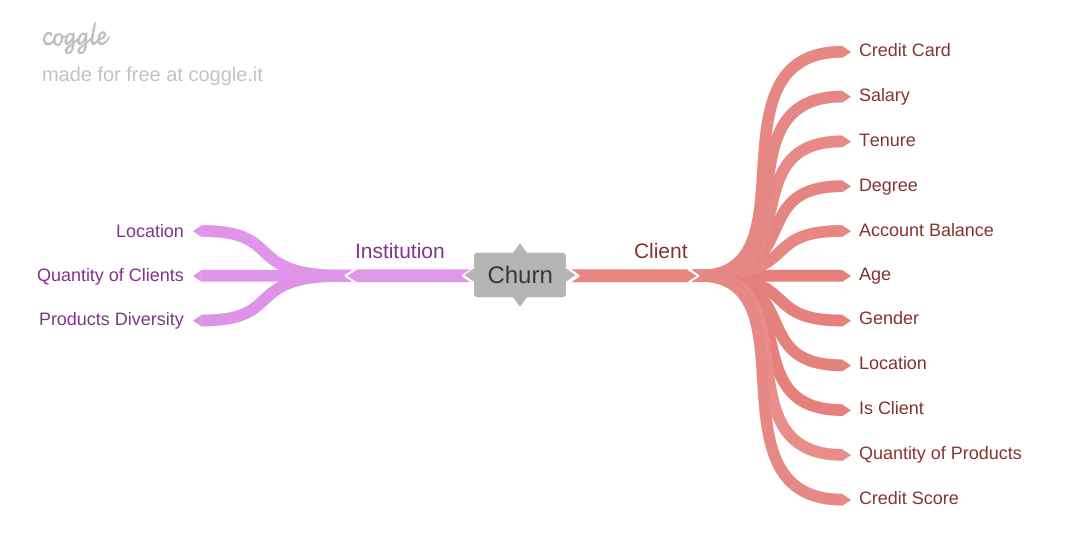

In [29]:
Image('../img/mind_map.png')

## 2.2. Hypothesis

**H1.** Customers with 4 years or less as bank customers are the largest number of active customers

**we have the amount of time the customer has a bank account and whether he is an active customer or not. Columns `tanure` and `is_active_member`**

**H2.** Clients over 40 years of age are the clients who least left the bank

**We have the customer's age and if it left the bank or not. Columns `age` and `exited`**

**H3.** Customers that purchased 2 or more products from the bank are the majority of active customers

**We have the number of products that the customer bought from the bank and if it is an active customer or not. Columns `num_of_products` and `is_active_member`**

**H4.** Customers with higher education degrees are the majority of customers that left the bank

**We don't have the customers degree information**

**H5.** Clients with Credit Score above 650 points are the majority of clients clients that left the bank

**We have the customer's credit score and if it left or not the bank. Columns `credit_score` and `exited`**

**H6.** Customers with an estimated salary above $ 99,735.00 are the majority of clients who left the bank.

**We have the client's estimated salary and if it left the bank or not. Columns `estimated_salary` and `exited`**

**H7.** Customers who have a credit card are the majority of customers who have left the bank

**We have the information if the client has or not a credit card and if it left or not the bank. Columns `has_cr_card` and `exited`**

**H8.** Male customers who have a credit card purchased more products that female customers that have a credit card

**We have the client's gender, if it has or not have a credit card and how many products it purchased from the bank. Columns `gender`, `has_cr_card` and `num_of_products`**

**H9.** Clients who have the highest median estimated salary are located in France.

**We have the client's estimated salary and the country that it came from. Columns `estimated_salary` e `geography`**

**H10.** Customers that have up to $40,000.00 in their accounts purchased fewer bank products, on average, compared to customers who have a larger account value.

**We have the client's balance account and how many products it purchased from the bank. Columns `balance` and `num_of_products`**

## 2.3. Chosen Hypothesis

**H1.** Customers with 4 years or less as bank customers are the largest number of active customers

**H3.** Customers that purchased 2 or more products from the bank are the majority of active customers

**H5.** Clients with Credit Score above 650 points are the majority of clients clients that left the bank

**H7.** Customers who have a credit card are the majority of customers who have left the bank

**H8.** Male customers who have a credit card purchased more products that female customers that have a credit card

## 2.4. Feature Engineering

In [30]:
# Class responsible for creating creadit_score_category feature. 
# It is inside utils directory
# This feature categorizes the clients based on theis credit score
# points
class CreditScoreCategoryFeature_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X.loc[:, 'credit_score_category'] = X.apply(self.credit_score_categorization, axis=1)
        return X
    
    def credit_score_categorization(self, row):
        credit_score = row['credit_score']
        
        if credit_score < 300:
            return 1
        elif credit_score <= 579:
            return 2
        elif credit_score <= 669:
            return 3
        elif credit_score <= 739:
            return 4
        elif credit_score < 799:
            return 5
        elif credit_score <= 850:
            return 6
        else:
            return 7

In [31]:
# Class responsible for creating estimated_monthly_salary feature. 
# It is inside utils directory
# This feature calculates the estimated monthly salary of the customers
class EstimatedMonthlySalaryFeature_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):    
        X.loc[:, 'estimated_monthly_salary'] = X.apply(self.estimated_monthly_salary, axis=1)
        return X
    
    def estimated_monthly_salary(self, row):
        return round(row['estimated_salary'] / 12, 2)


In [32]:
# Class responsible for creating products_used_by_year feature. 
# It is inside utils directory
# This feature calculetes the ratio of products purchased by year
# for the customers
class ProductsUsedByYearFeature_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[:, 'products_used_year'] = X.apply(self.products_used_by_year, axis=1)
        
        return X
        
    def products_used_by_year(self, row):
        if row['num_of_products'] <= 0:
            return 0
        elif row['tenure'] <= 0:
            return row['num_of_products']
        else:
            return round(row['num_of_products'] / row['tenure'], 2)


In [33]:
# Create Feature Creation Pipeline
feature_eng_pipe = Pipeline([
    ('credit_score', utils.CreditScoreCategoryFeature()),
    ('estimated_salary', utils.EstimatedMonthlySalaryFeature()),
    ('products_used', utils.ProductsUsedByYearFeature()),
])

# Create Fetures using the Pipeline
df_2 = feature_eng_pipe.fit_transform(df2, df2.drop('exited', axis='columns'))

# Selected columns and new features
cols = [
    'credit_score',
    'credit_score_category',
    'estimated_salary',
    'estimated_monthly_salary',
    'num_of_products',
    'tenure',
    'products_used_year',
]

# Show new features and originary columns
df_2.loc[:, cols].sample(5)

,credit_score,credit_score_category,estimated_salary,estimated_monthly_salary,num_of_products,tenure,products_used_year
5974,773,5,113950.51,9495.88,1,8,0.12
1251,588,3,121504.18,10125.35,1,10,0.10
4236,492,2,39519.53,3293.29,2,4,0.50
1302,428,2,54487.43,4540.62,2,2,1.00
5788,602,3,169921.11,14160.09,2,10,0.20


# 3.0. Features Filtering

In [34]:
df3 = df2.copy()

## 3.1. Lines Filtering

There's no line filtering in the iteration.

## 3.2. Columns Filtering

In [35]:
# Class responsible for filtering columns from the DataFrame. 
# It is inside utils directory
class FilterColumns_(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis = 1) if self.columns else X


In [36]:
# Create filtering Pipeline
filter_columns_pipe = Pipeline([
    ('filter_columns', utils.FilterColumns(columns=['customer_id', 'surname', 'row_number']))
])

# Filter Columns using Pipeline
df3 = filter_columns_pipe.transform(df3)

# 4.0. EDA

In [37]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Feature

Saving figure univariate_analysis_target


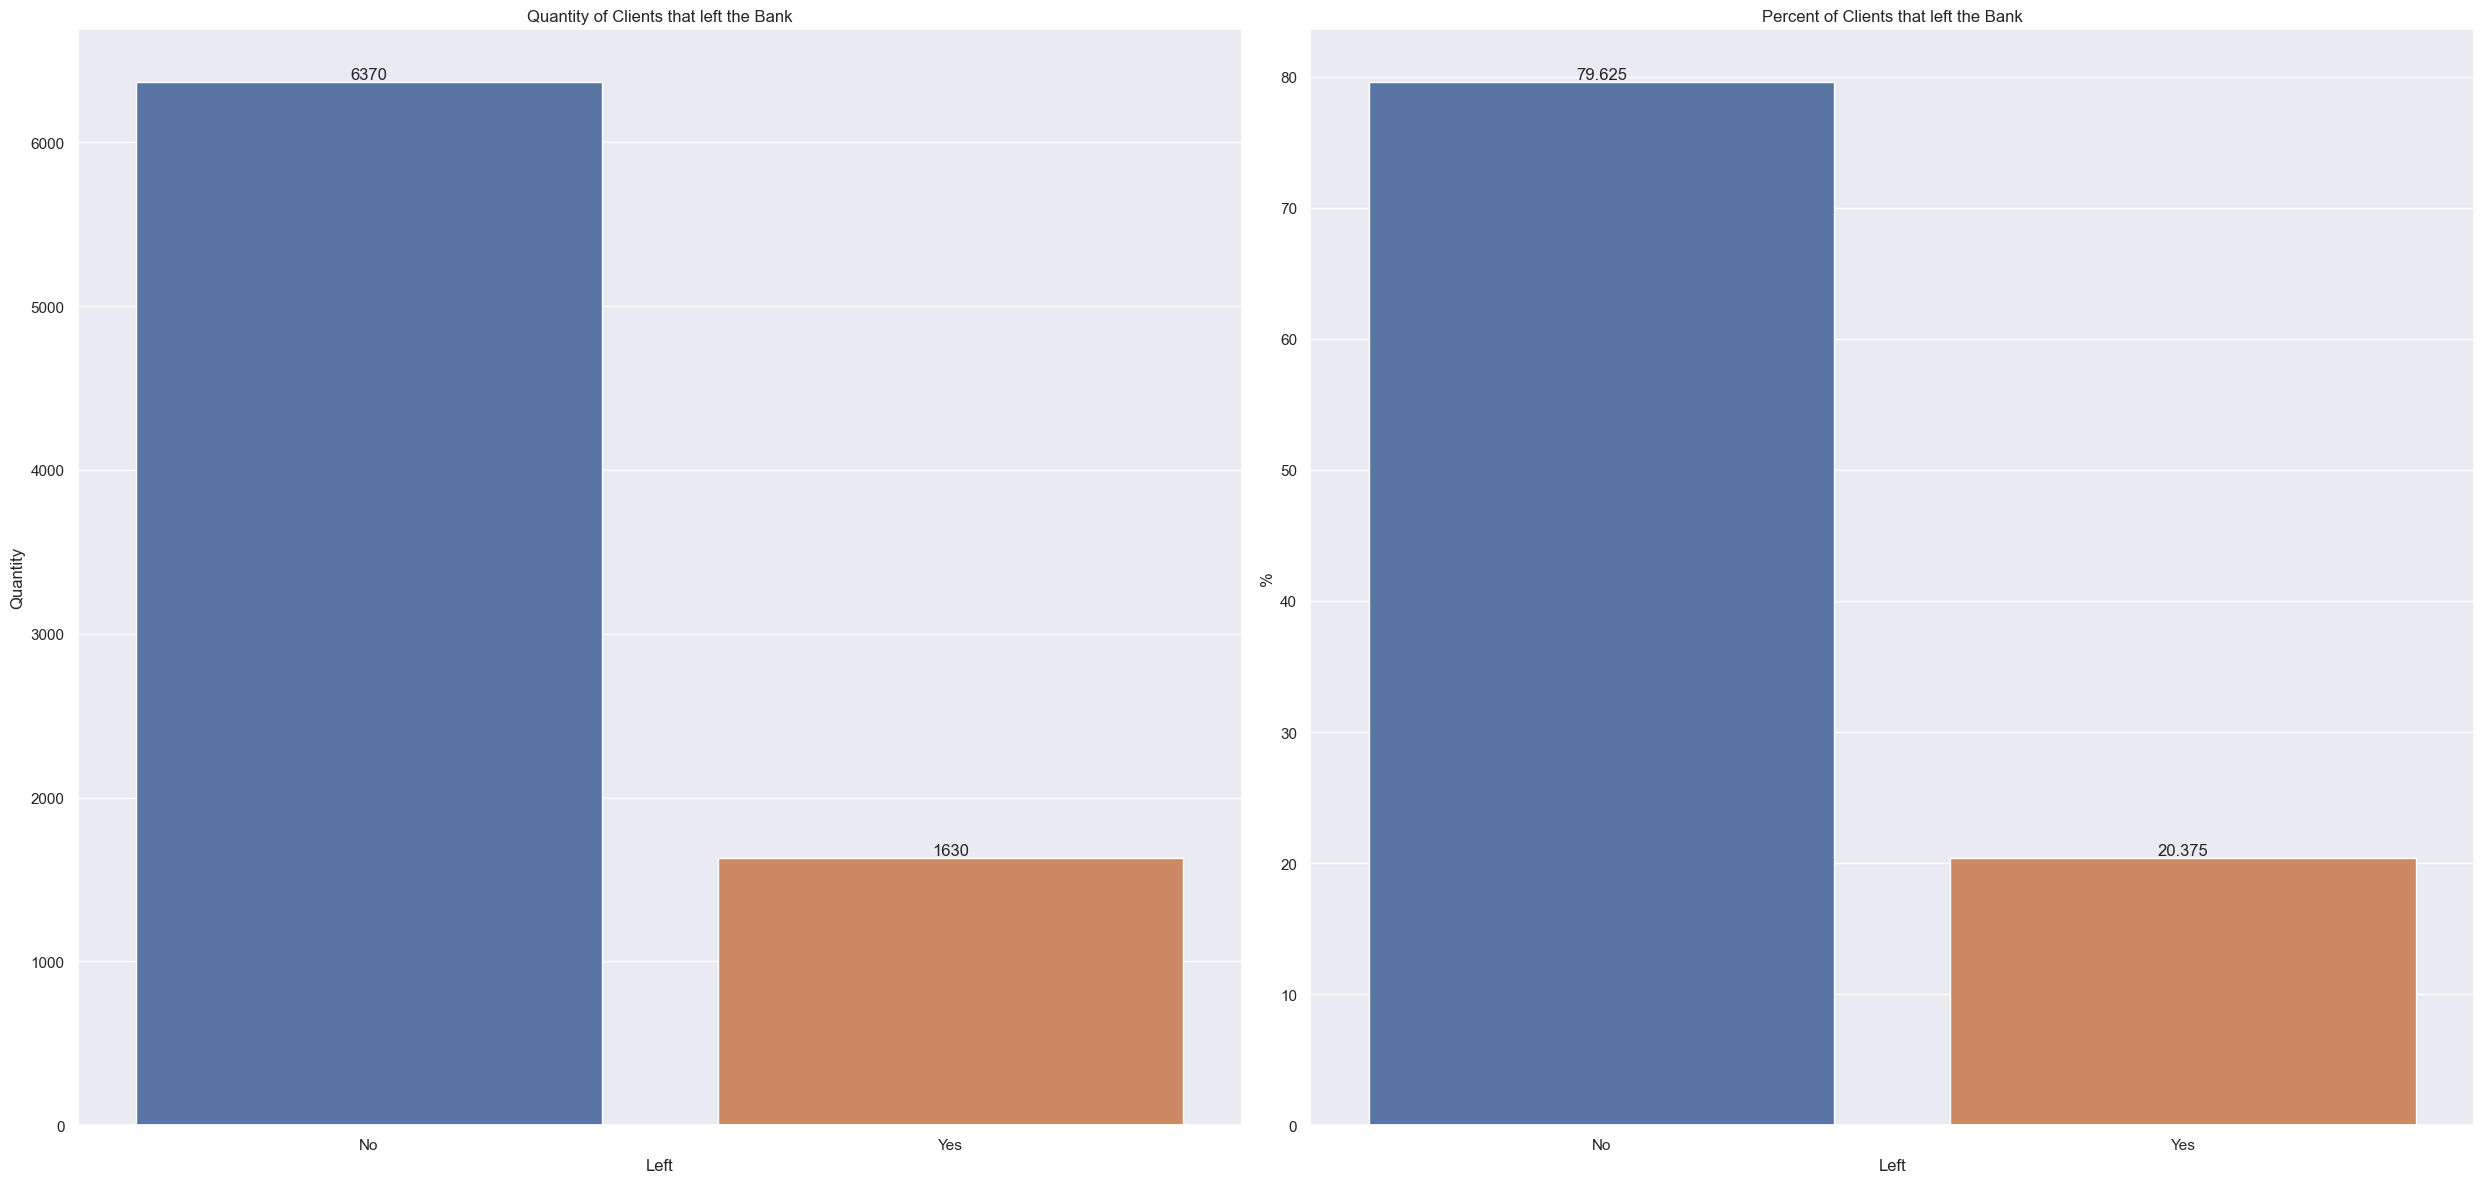

In [255]:
# Group customers by exited feature and count them
df_g = df4.loc[:, ['gender', 'exited']].groupby('exited').agg(
    count = pd.NamedAgg('exited', 'count'),
).reset_index()

# Calculate the percentage of clients that left and remained in
# the bank as a customers
df_g['percent'] = df_g['count'].apply(lambda count: count / df4.shape[0] * 100)

# Rename exited categories to Yes or No
df_g['exited'] = df_g['exited'].apply(lambda exited: 'Yes' if exited == 1 else 'No')

# Create a plots to show how many customer left and remained 
# in the bank as a customer exists in the dataset. This wil give us the
# Churn rate
plt.subplot(1, 2, 1)
ax = sns.barplot(data=df_g, x='exited', y='count');
ax.bar_label(ax.containers[0])
ax.set(title='Quantity of Clients that left the Bank', xlabel='Left', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='percent', data=df_g);
ax.bar_label(ax.containers[0])
ax.set(title='Percent of Clients that left the Bank', xlabel='Left', ylabel='%');
save_fig('univariate_analysis_target')

The actual `Churn` rate from the bank is `20.375%`

### 4.1.2. Numerical Features

Saving figure univariate_numerical_analysis


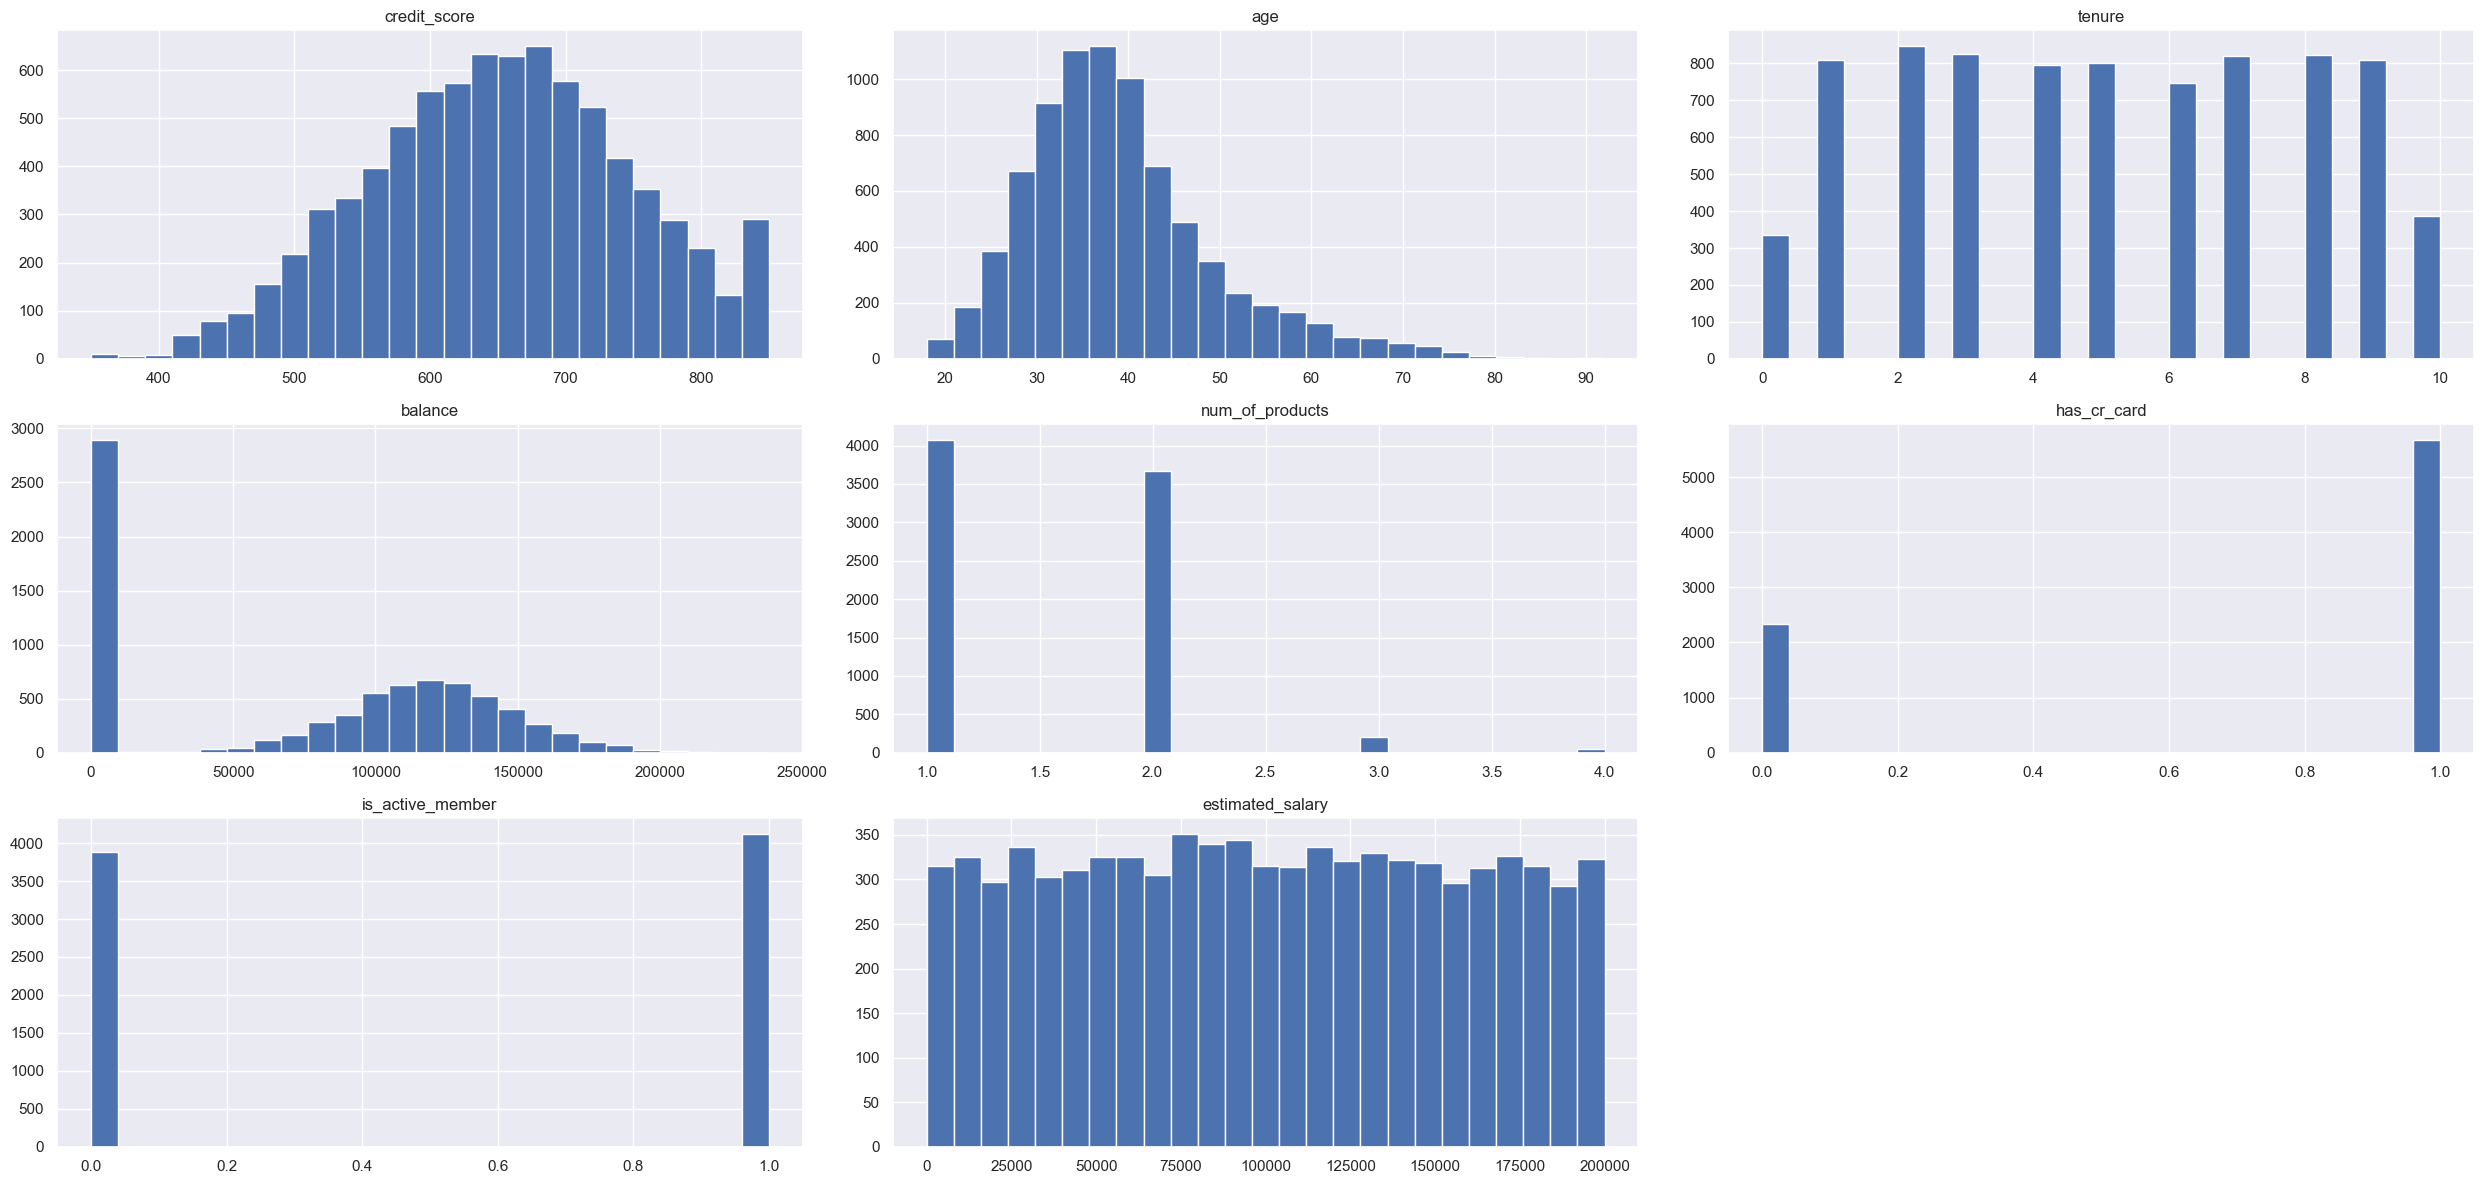

In [256]:
# Create a distribution plots of all numerical attributes 
num_attributes.drop('customer_id', axis=1).hist(bins=25);
save_fig('univariate_numerical_analysis')

Besides the previous analysis of the `estimated_salaray` and `balance` features, we can see that:
* `credit_score` feature has a spike around 850 points, with approximately 300 costumers. Must be investigated to determine if this observations aren't outliers.
* `age` feature indicates that the bank customers are concentrated between 30 and 45 years
* `tenure` feature has around 300 customers with zero. Must be investigated to determine to understand these custumers
* `has_cr_card` feature indicates that the majority of the bank customers have a credit card
* `is_active_member` feature indicates that the quantity of clientes that are active and not are approximately the same

`credit_score`, `tenure`, `estimated_salaray` and `balance` will be investigated deeply in the next iteration.

### 4.1.3. Categorical Features

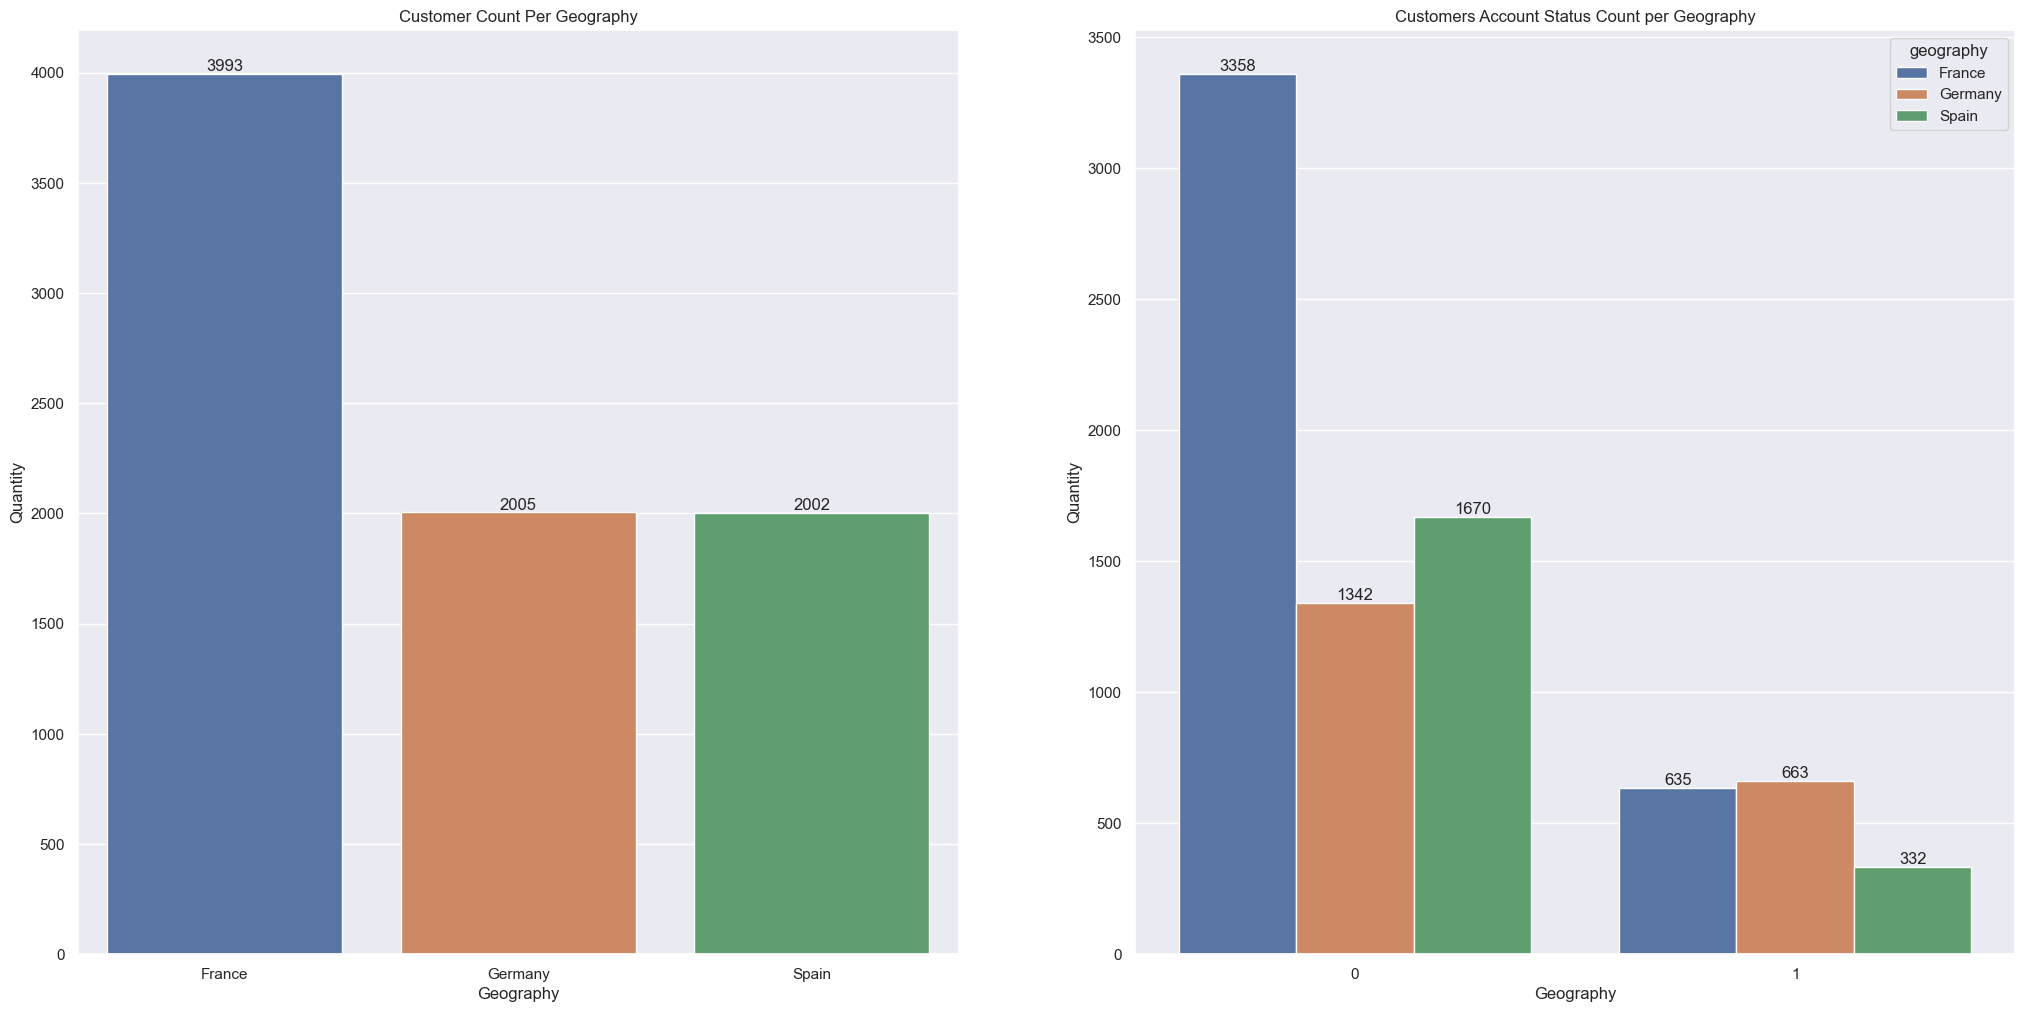

In [40]:
# It's the same analysis did before
geography = df1.loc[ :, ['row_number', 'geography'] ].groupby(['geography']).count().reset_index()
ext_geography = df1.loc[ :, ['row_number', 'exited', 'geography'] ].groupby(['exited', 'geography']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(x='geography', y='row_number', data=geography)
ax.bar_label(ax.containers[0])
ax.set(title='Customer Count Per Geography', xlabel='Geography', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_geography, hue='geography');
for index in ax.containers:
    ax.bar_label(index, )
ax.set(title='Customers Account Status Count per Geography', xlabel='Geography', ylabel='Quantity');

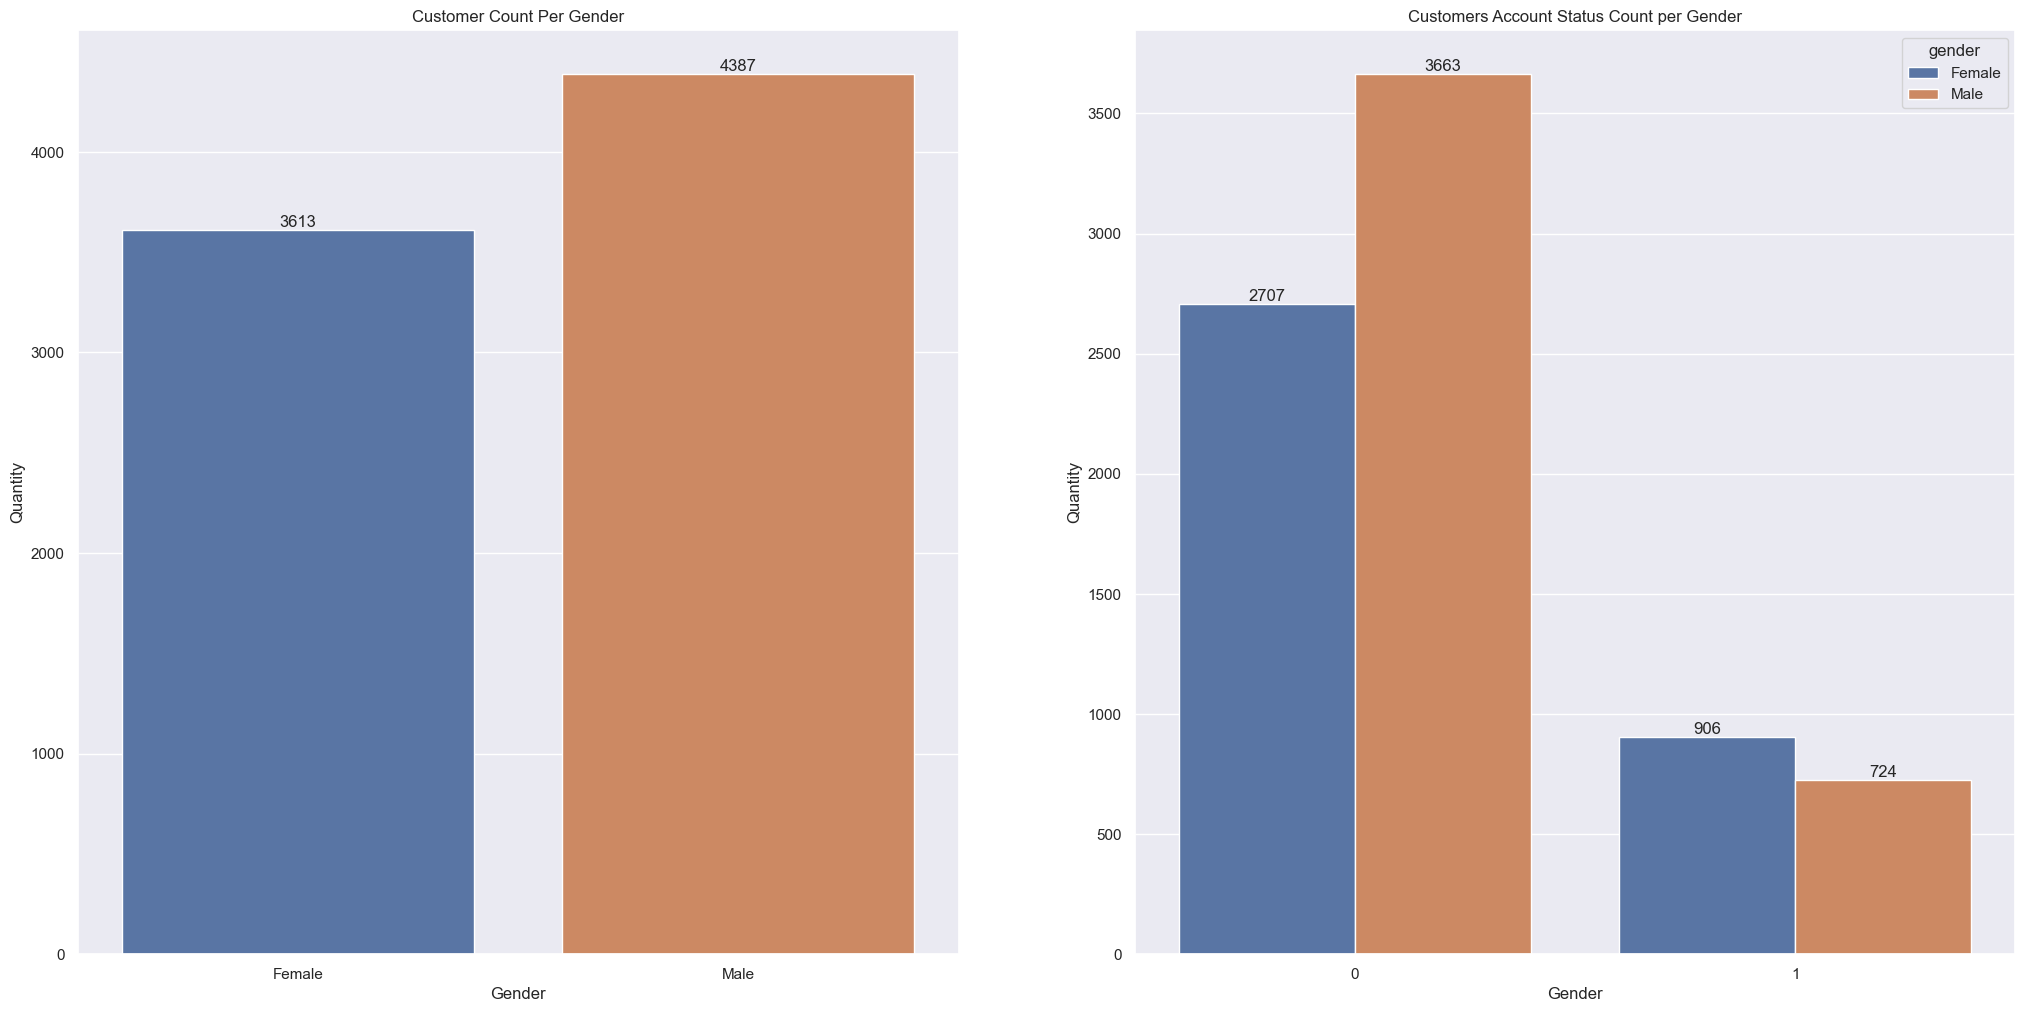

In [41]:
gender = df1.loc[ :, ['row_number', 'gender'] ].groupby(['gender']).count().reset_index()
ext_gender = df1.loc[ :, ['row_number', 'exited', 'gender'] ].groupby(['exited', 'gender']).count().reset_index()

plt.subplot(1, 2, 1)
ax = sns.barplot(x='gender', y='row_number', data=gender)
ax.bar_label(ax.containers[0])
ax.set(title='Customer Count Per Gender', xlabel='Gender', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='exited', y='row_number', data=ext_gender, hue='gender');
for index in ax.containers:
    ax.bar_label(index, )
ax.set(title='Customers Account Status Count per Gender', xlabel='Gender', ylabel='Quantity');

Initally we already have done these analyses. In the next interations, some more analyses culd be done, like the proportion of active clients by gender and geography, average balance per geography, etc.

## 4.2. Bivariate Analysis

### 4.2.1. H1. Customers with 4 years or less as bank customers are the largest number of active customers

**FALSE** - Customers who have been 4 years or less as bank's clients aren't the largest active costumers

Saving figure h1_01_img


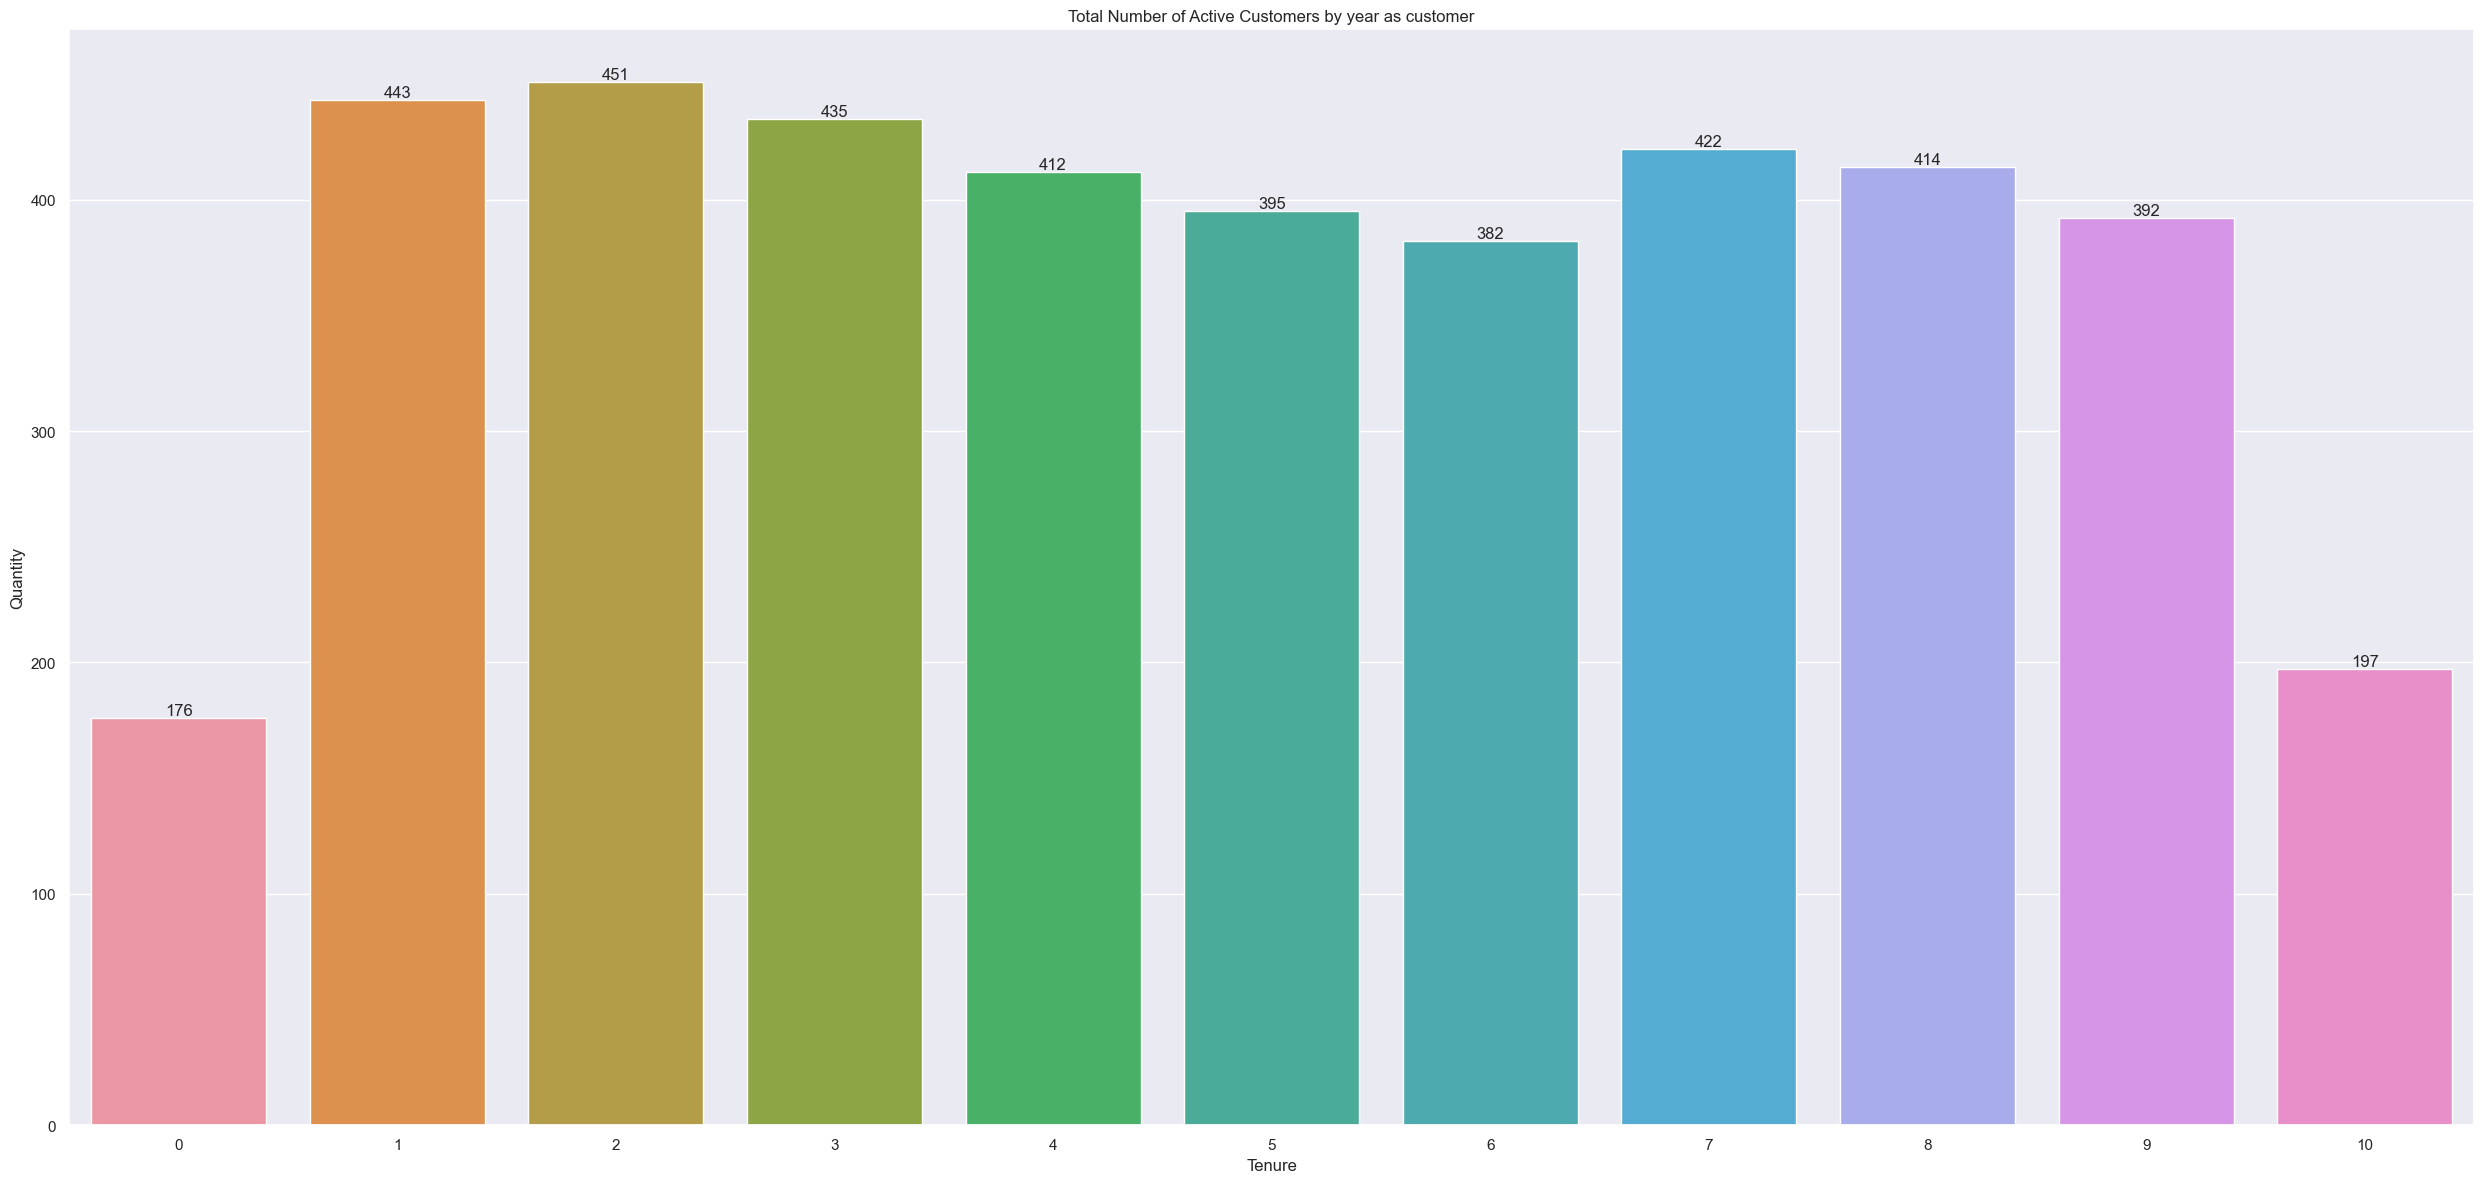

In [228]:
df_g = df4.loc[ df4['is_active_member'] == 1, ['tenure', 'age'] ].groupby('tenure').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()

ax = sns.barplot(data=df_g, x='tenure', y='count')
ax.bar_label(ax.containers[0])
ax.set(
    title='Total Number of Active Customers by year as customer', 
    xlabel='Tenure', 
    ylabel='Quantity'
);

save_fig('h1_01_img')

Saving figure h1_02_img


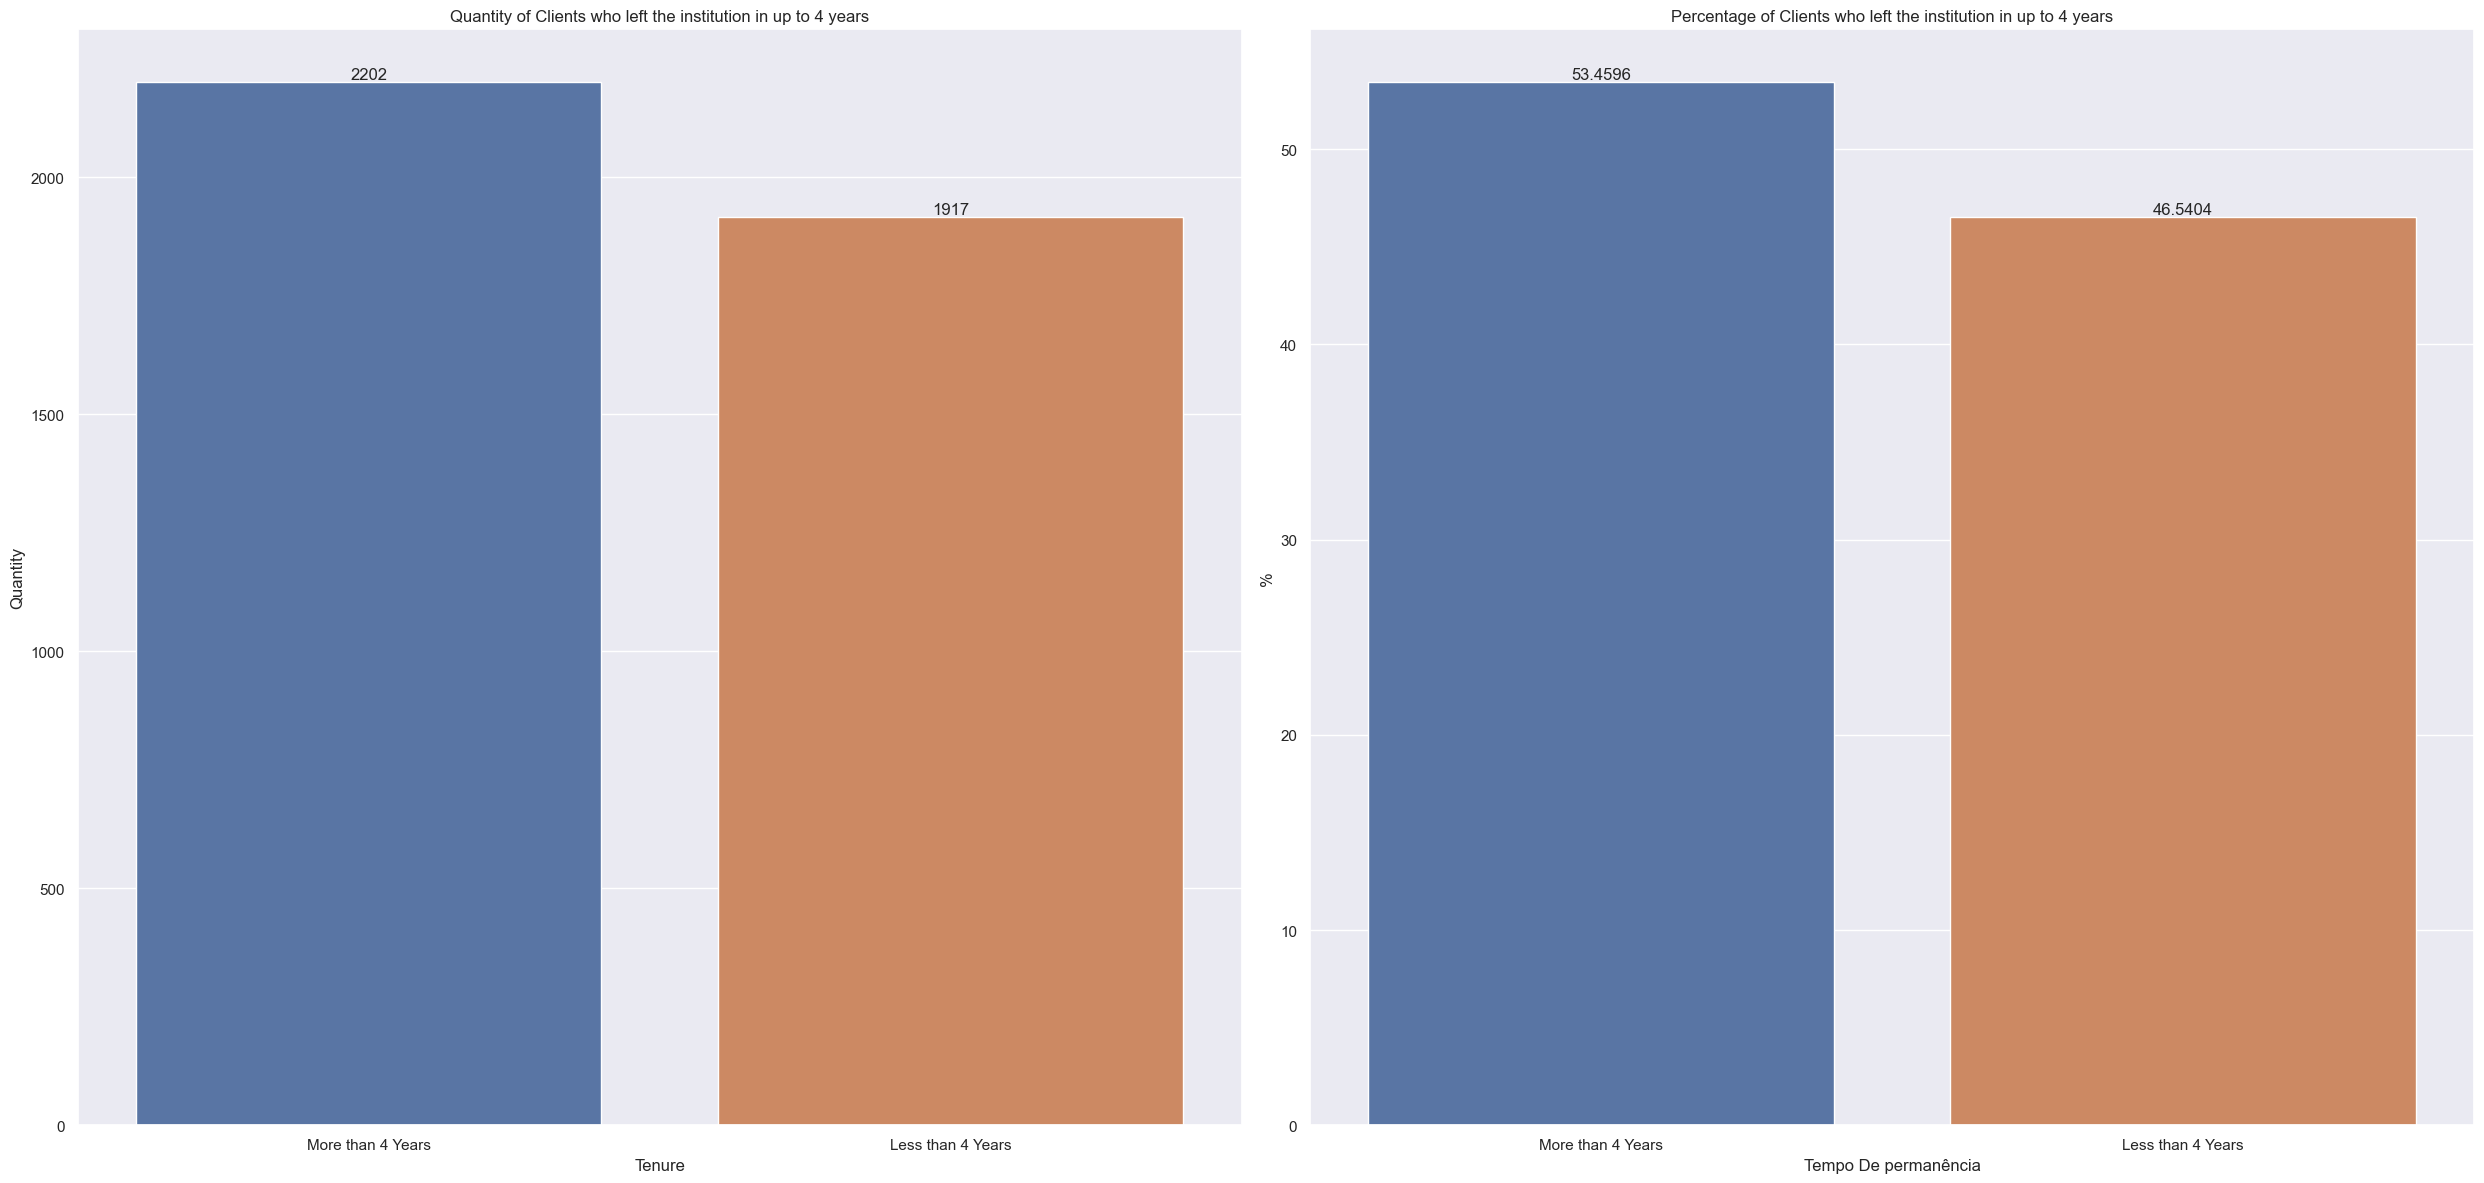

In [229]:
df_g = df4.loc[ df4['is_active_member'] == 1, ['tenure', 'age'] ].groupby('tenure').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()


lower = df_g.loc[ df_g['tenure'] <= 4, 'count'].sum()
higher = df_g.loc[ df_g['tenure'] > 4, 'count'].sum()

df_aux = pd.DataFrame({
    'tenure': ['More than 4 Years', 'Less than 4 Years'],
    'count': [higher, lower]
})

df_aux['percent'] = df_aux['count'].apply(lambda count: count / df_g['count'].sum() * 100)

plt.subplot(1, 2, 1)
ax = sns.barplot(data=df_aux, x='tenure', y='count')
ax.bar_label(ax.containers[0])
ax.set(title='Quantity of Clients who left the institution in up to 4 years', xlabel='Tenure', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(data=df_aux, x='tenure', y='percent')
ax.bar_label(ax.containers[0])
ax.set(title='Percentage of Clients who left the institution in up to 4 years', xlabel='Tempo De permanência', ylabel='%');

save_fig('h1_02_img')

### 4.2.2. H3. Customers that purchased 2 or more products from the bank are the majority of active customers

**TRUE** - Customers who purchased 2 or more products are the majority of the bank's active customers

Saving figure h3_01_img


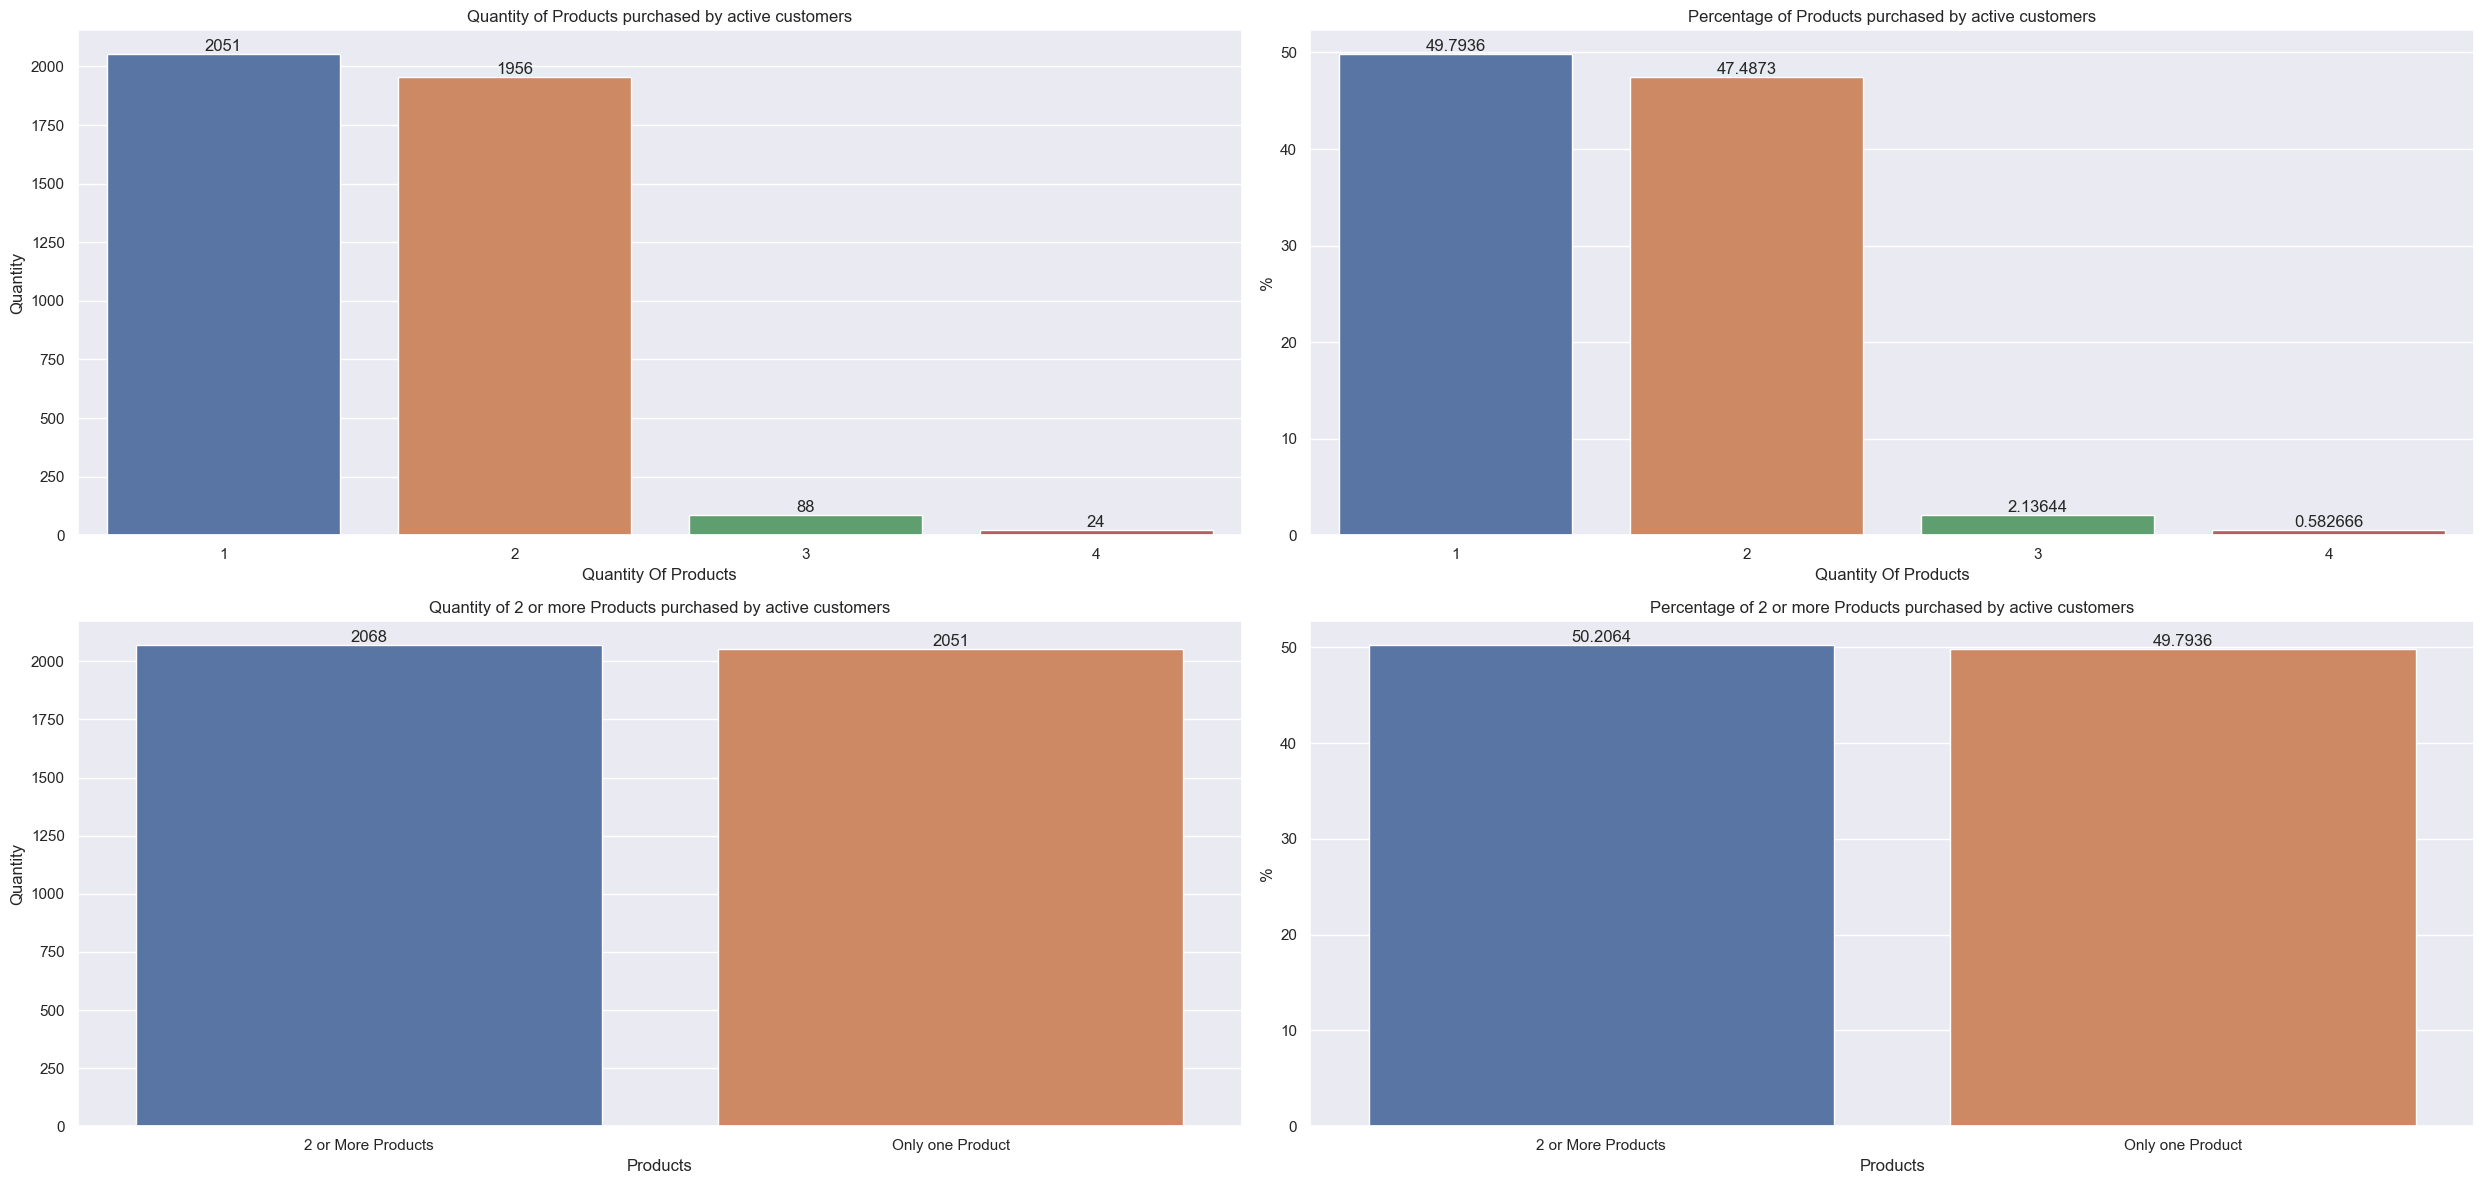

In [231]:
df_g1 = df4.loc[ df4['is_active_member'] == 1, ['num_of_products', 'age'] ].groupby('num_of_products').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()

df_g1['percent'] = df_g1['count'].apply(lambda count: count / df_g1['count'].sum() * 100) 

lower = df_g1.loc[ df_g1['num_of_products'] <= 1, 'count'].sum()
higher = df_g1.loc[ df_g1['num_of_products'] > 1, 'count'].sum()

df_aux = pd.DataFrame({
    'num_of_products': ['2 or More Products', 'Only one Product'],
    'count': [higher, lower]
})

df_aux['percent'] = df_aux['count'].apply(lambda count: count / df_g1['count'].sum() * 100)


plt.subplot(2, 2, 1)
ax = sns.barplot(x='num_of_products', y='count', data=df_g1);
ax.bar_label(ax.containers[0])
ax.set(title='Quantity of Products purchased by active customers', xlabel='Quantity Of Products', ylabel='Quantity');

plt.subplot(2, 2, 2)
ax = sns.barplot(x='num_of_products', y='percent', data=df_g1);
ax.bar_label(ax.containers[0])
ax.set(title='Percentage of Products purchased by active customers', xlabel='Quantity Of Products', ylabel='%');

plt.subplot(2, 2, 3)
ax = sns.barplot(x='num_of_products', y='count', data=df_aux);
ax.bar_label(ax.containers[0])
ax.set(title='Quantity of 2 or more Products purchased by active customers', xlabel='Products', ylabel='Quantity');

plt.subplot(2, 2, 4)
ax = sns.barplot(x='num_of_products', y='percent', data=df_aux);
ax.bar_label(ax.containers[0])
ax.set(title='Percentage of 2 or more Products purchased by active customers', xlabel='Products', ylabel='%');

save_fig('h3_01_img')

### 4.2.3. H5. Clients with Credit Score above 650 points are the majority of clients clients that left the bank

**FALSE** - Clients with a credit score above 650 points are the clients that REMAINED the most as clients of the bank

Saving figure h5_01_img


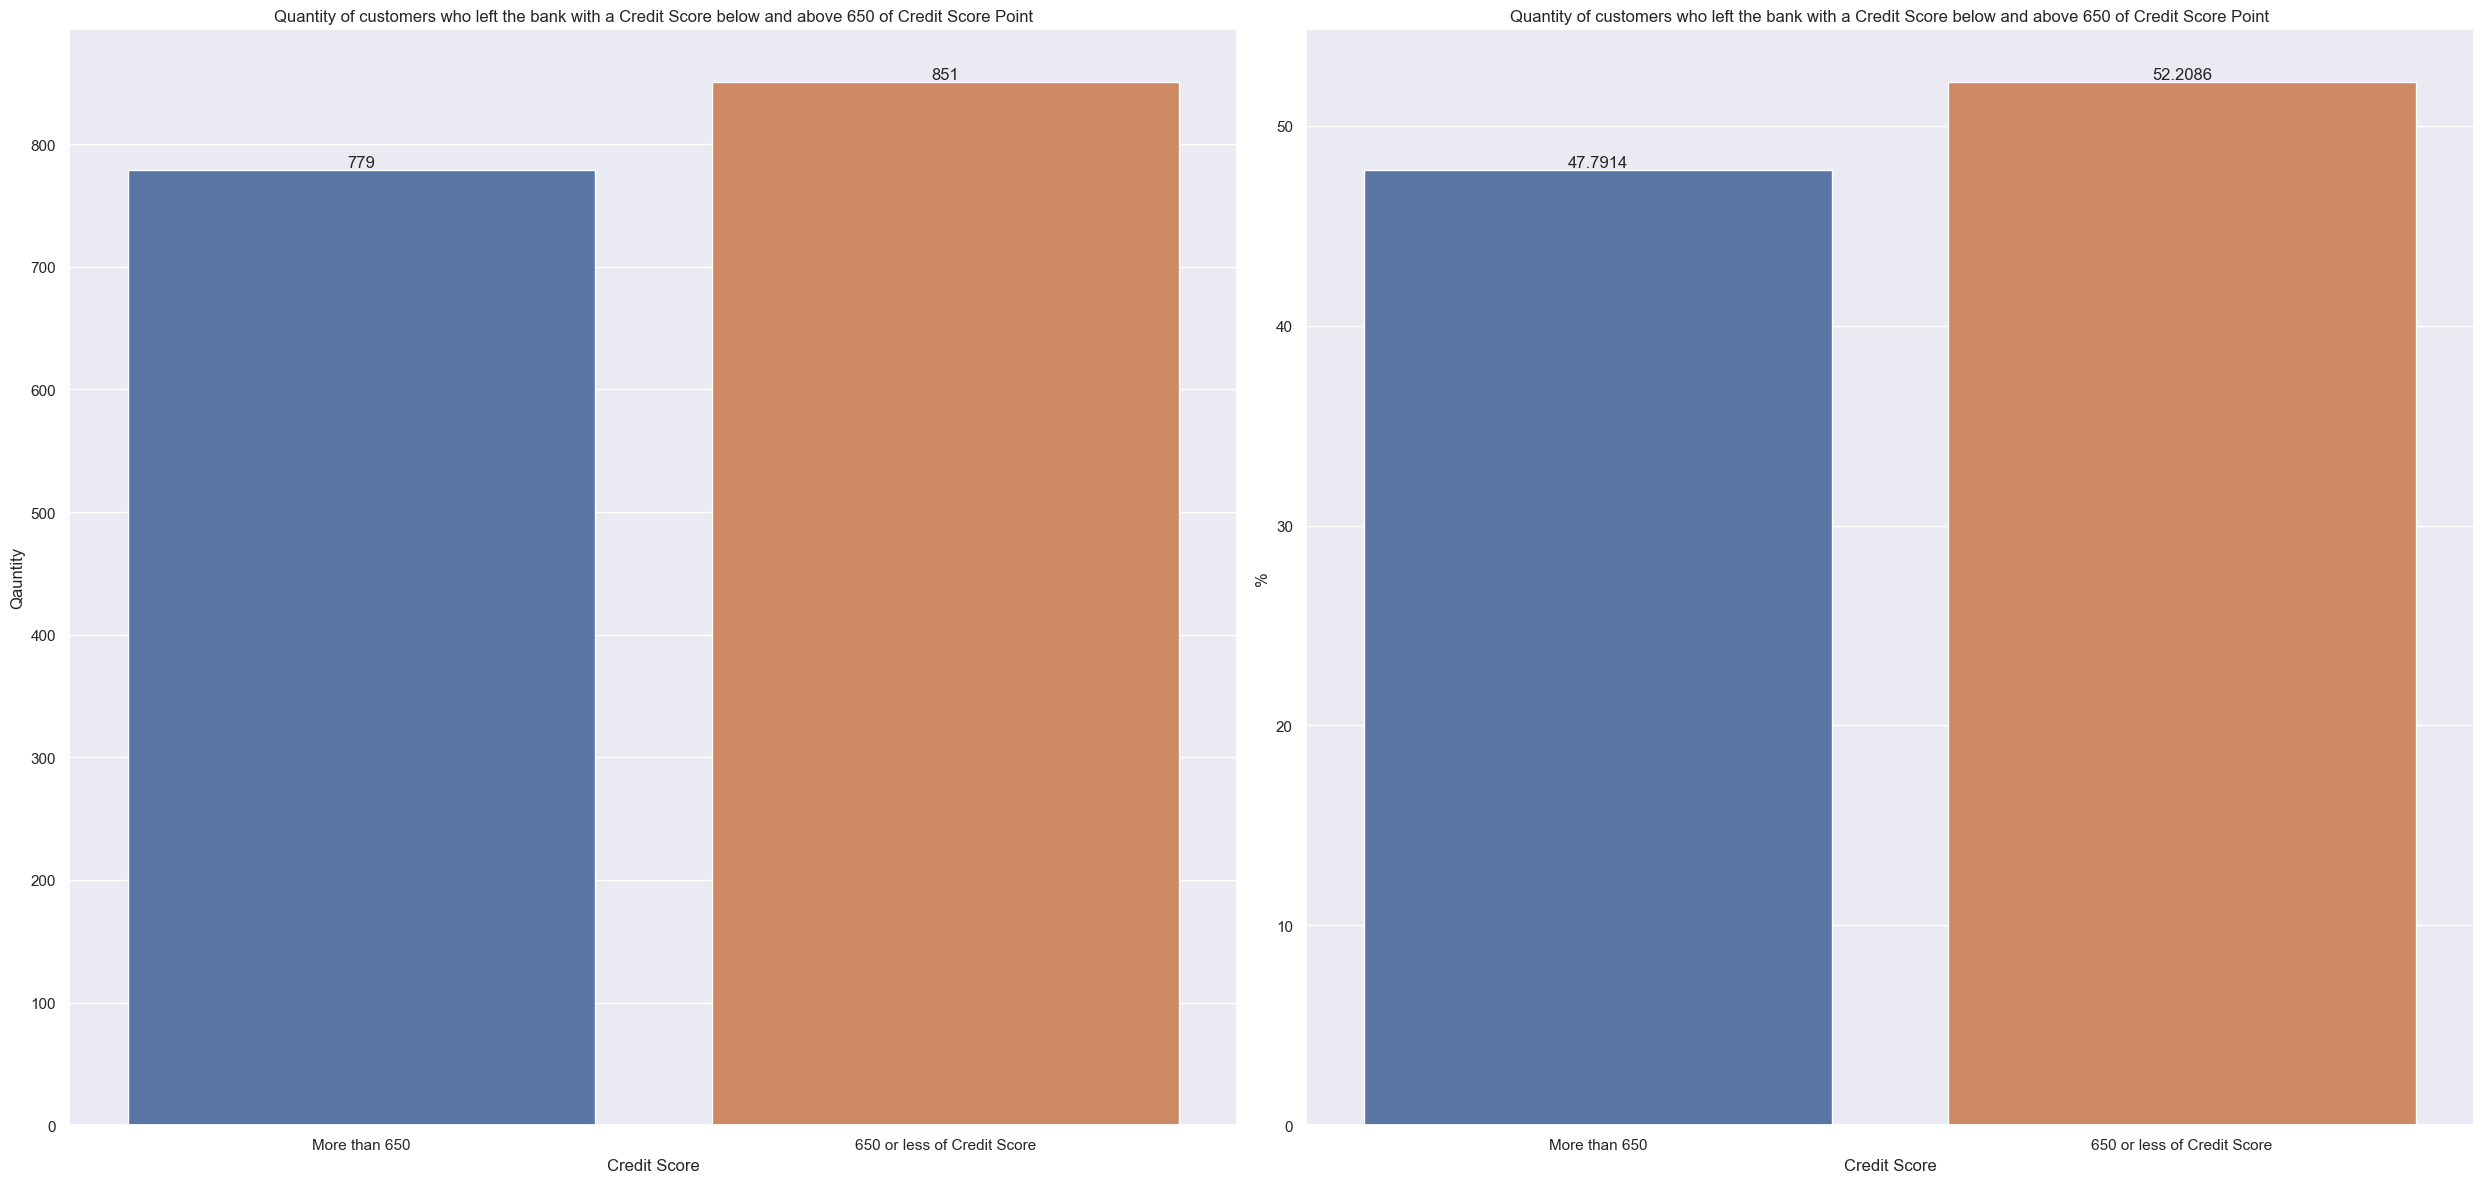

In [232]:
df_g = df4.loc[ (df4['exited'] == 1), ['credit_score', 'age'] ].groupby('credit_score').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()

lower = df_g.loc[ df_g['credit_score'] <= 650, 'count'].sum()
higher = df_g.loc[ df_g['credit_score'] > 650, 'count'].sum()

df_aux = pd.DataFrame({
    'credit_score': ['More than 650', '650 or less of Credit Score'],
    'count': [higher, lower]
})

df_aux['percent'] = df_aux['count'].apply(lambda count: count / df_g['count'].sum() * 100)

plt.subplot(1, 2, 1)
ax = sns.barplot(data=df_aux, x='credit_score', y='count')
ax.bar_label(ax.containers[0])
ax.set(
    title='Quantity of customers who left the bank with a Credit Score below and above 650 of Credit Score Point', 
    xlabel='Credit Score', 
    ylabel='Qauntity'
);

plt.subplot(1, 2, 2)
ax = sns.barplot(data=df_aux, x='credit_score', y='percent')
ax.bar_label(ax.containers[0])
ax.set(
    title='Quantity of customers who left the bank with a Credit Score below and above 650 of Credit Score Point', 
    xlabel='Credit Score', 
    ylabel='%'
);

save_fig('h5_01_img')

### 4.2.4. H7. Customers who have a credit card are the majority of customers who left the bank

**TRUE** - Customers that have a credit card are the majority of customers that left in the bank

Saving figure h7_01_img


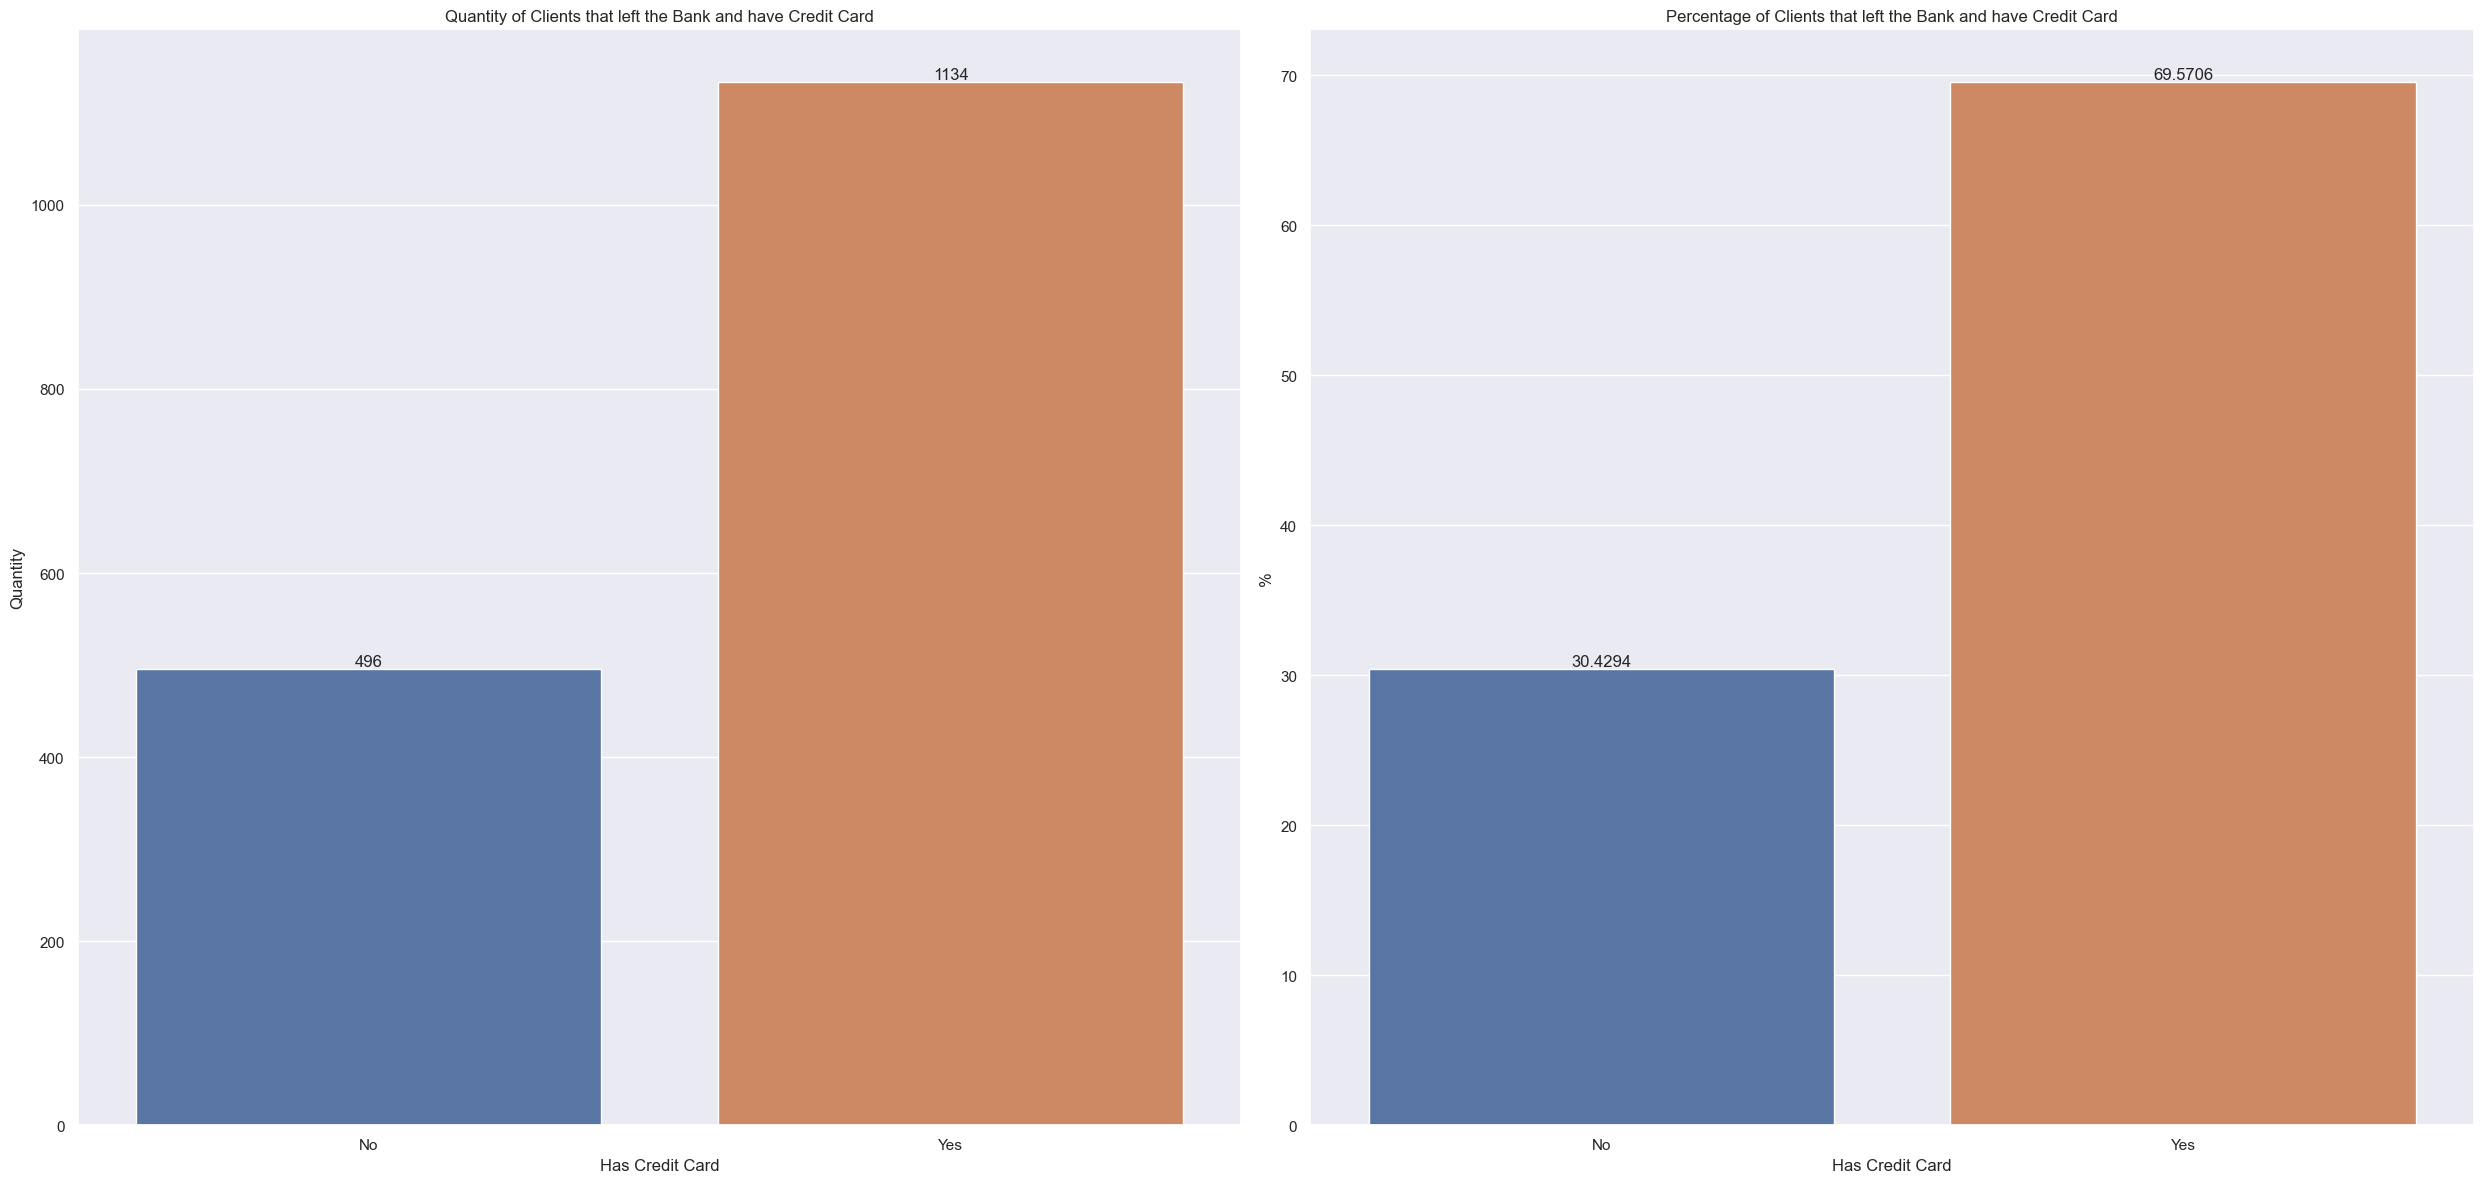

In [233]:
df_g = df4.loc[ df4['exited'] == 1, ['has_cr_card', 'age'] ].groupby('has_cr_card').agg(
    count = pd.NamedAgg('age', 'count')
).reset_index()

total = df4.loc[df4['exited'] == 1, :].shape[0]

df_g['percent'] = df_g['count'].apply(lambda count: count / total * 100)

df_g['has_cr_card'] = df_g['has_cr_card'].apply(lambda has_cr_card: 'Yes' if has_cr_card == 1 else 'No')

plt.subplot(1, 2, 1)
ax = sns.barplot(data=df_g, x='has_cr_card', y='count');
ax.bar_label(ax.containers[0])
ax.set(title='Quantity of Clients that left the Bank and have Credit Card', xlabel='Has Credit Card', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='has_cr_card', y='percent', data=df_g);
ax.bar_label(ax.containers[0])
ax.set(title='Percentage of Clients that left the Bank and have Credit Card', xlabel='Has Credit Card', ylabel='%');

save_fig('h7_01_img')

### 4.2.5. H8. Male customers who have a credit card purchased more products that female customers that have a credit card

**TRUE** - Male customers that have a credit card purchased more products from the bank than female customers that have a credit card

Saving figure h8_01_img


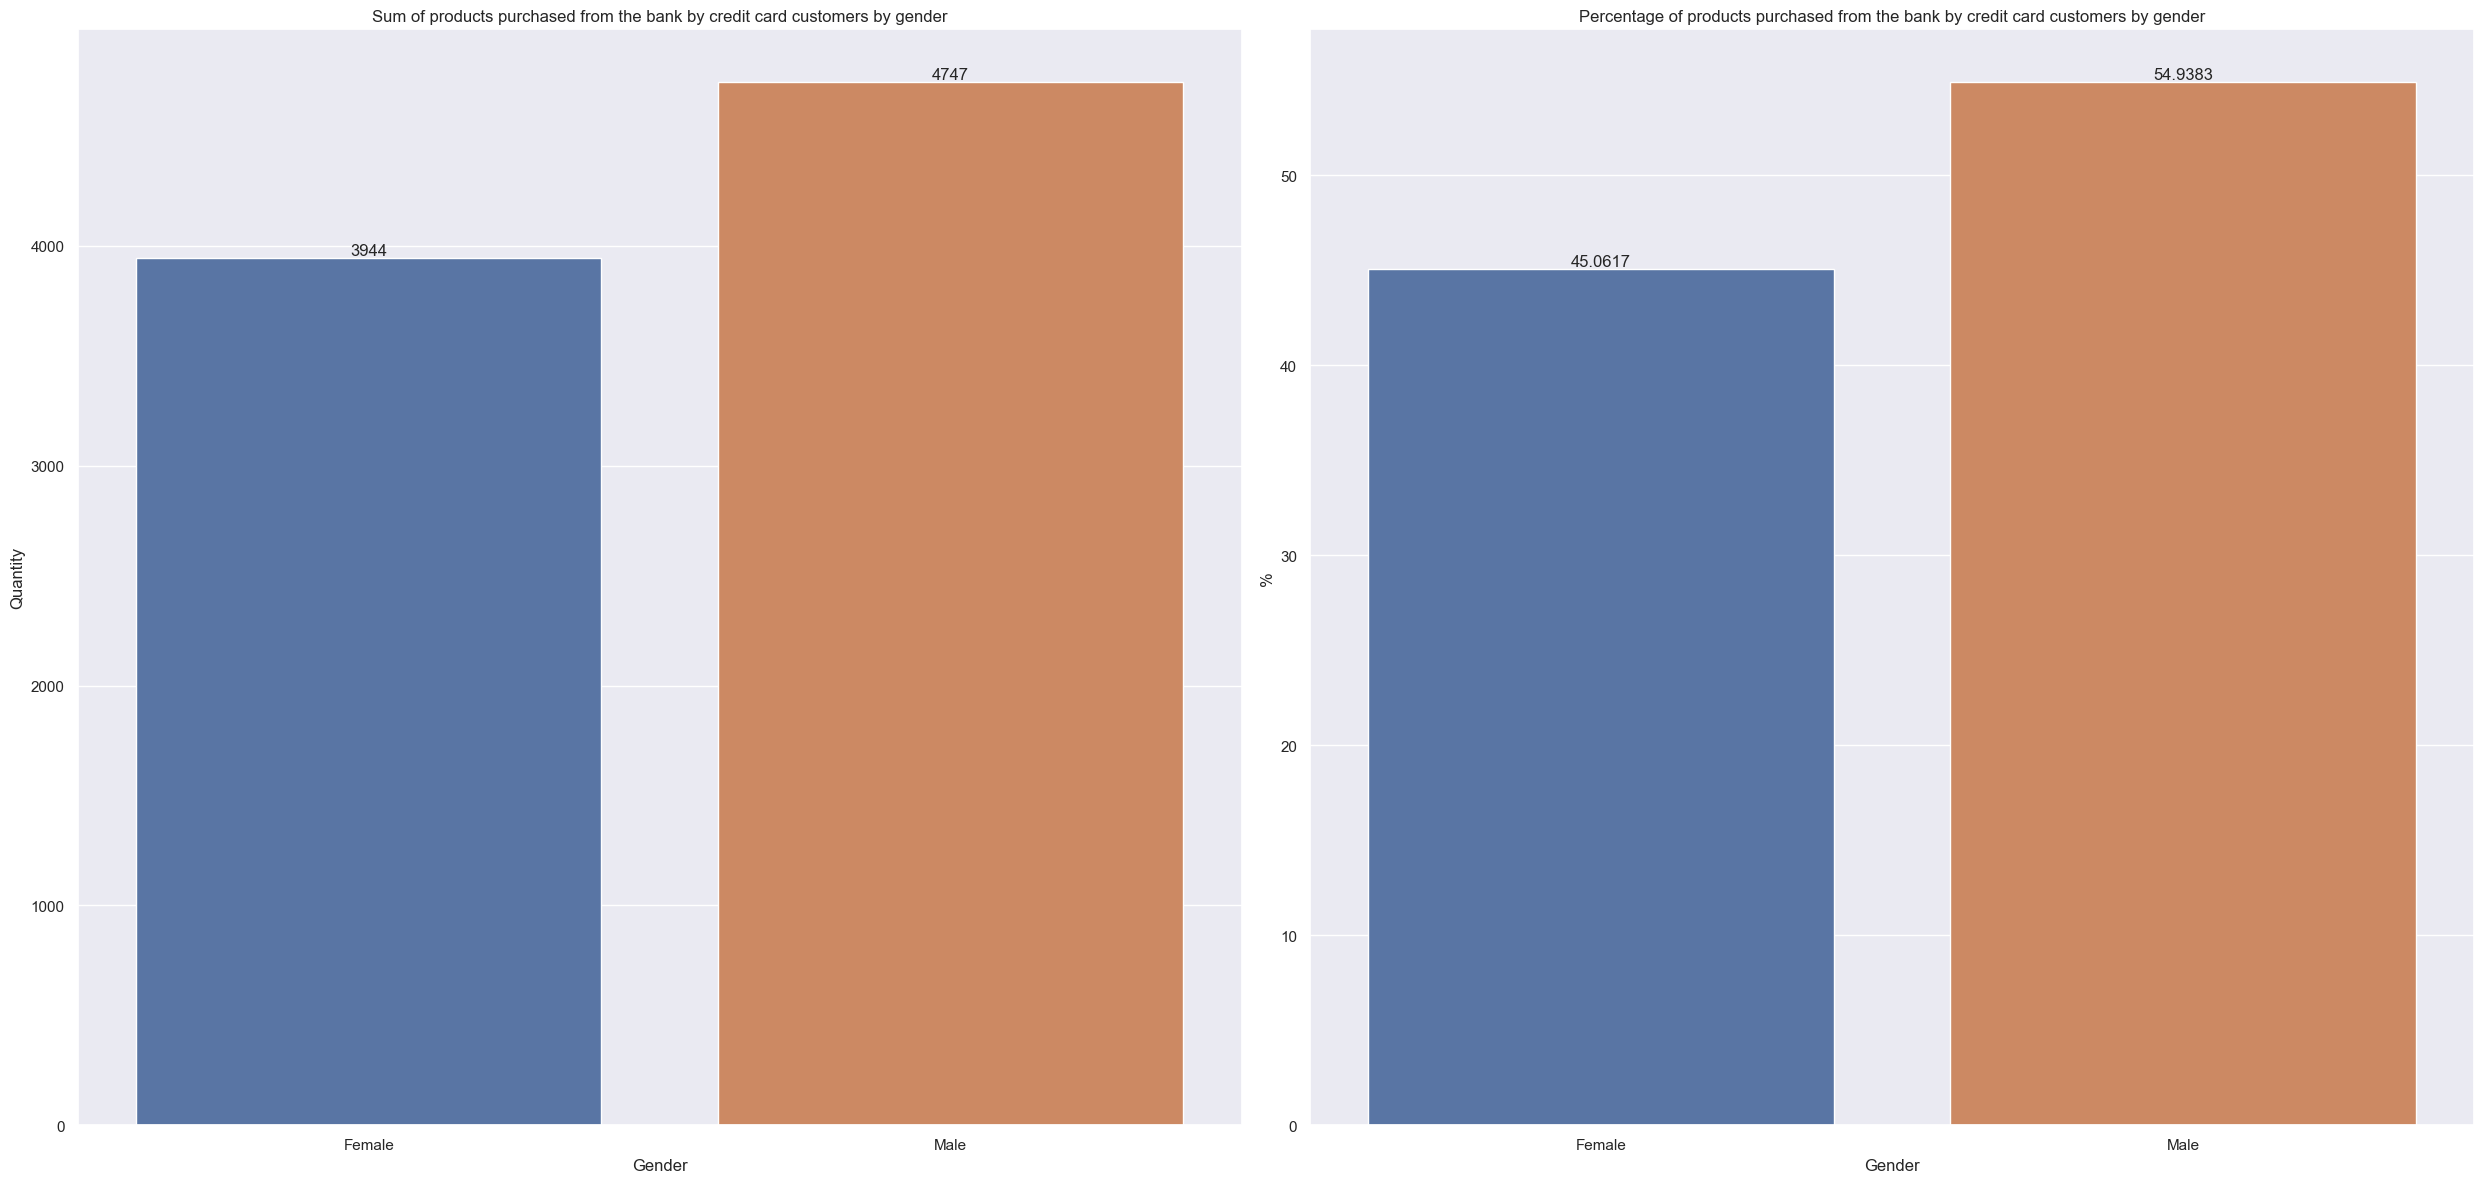

In [234]:
df_g = df4.loc[ df4['has_cr_card'] == 1, ['gender', 'num_of_products'] ].groupby('gender').agg(
    sum = pd.NamedAgg('num_of_products', 'sum'),
    count = pd.NamedAgg('num_of_products', 'count'),
).reset_index()

total = df4.loc[ df4['has_cr_card'] == 1, : ].shape[0]

df_g['percent'] = df_g['count'].apply(lambda count: count / total * 100)

plt.subplot(1, 2, 1)
ax = sns.barplot(data=df_g, x='gender', y='sum');
ax.bar_label(ax.containers[0])
ax.set(title='Sum of products purchased from the bank by credit card customers by gender', xlabel='Gender', ylabel='Quantity');

plt.subplot(1, 2, 2)
ax = sns.barplot(x='gender', y='percent', data=df_g);
ax.bar_label(ax.containers[0])
ax.set(title='Percentage of products purchased from the bank by credit card customers by gender', xlabel='Gender', ylabel='%');

save_fig('h8_01_img')

### 4.2.6. Hypothesis Analysis

| Hypothesis | Conclusion | Relevance |
| :--------- | :--------- | :-------- |
| H1 | FALSE | Low |
| H2 | - | - |
| H3 | TRUE | Low |
| H4 | - | - |
| H5 | FALSE | High |
| H6 | - | - |
| H7 | TRUE | High |
| H8 | TRUE | Low |
| H9 | - | - |
| H10 | - | - |

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Features

Saving figure heatmap_multivariate_correlation


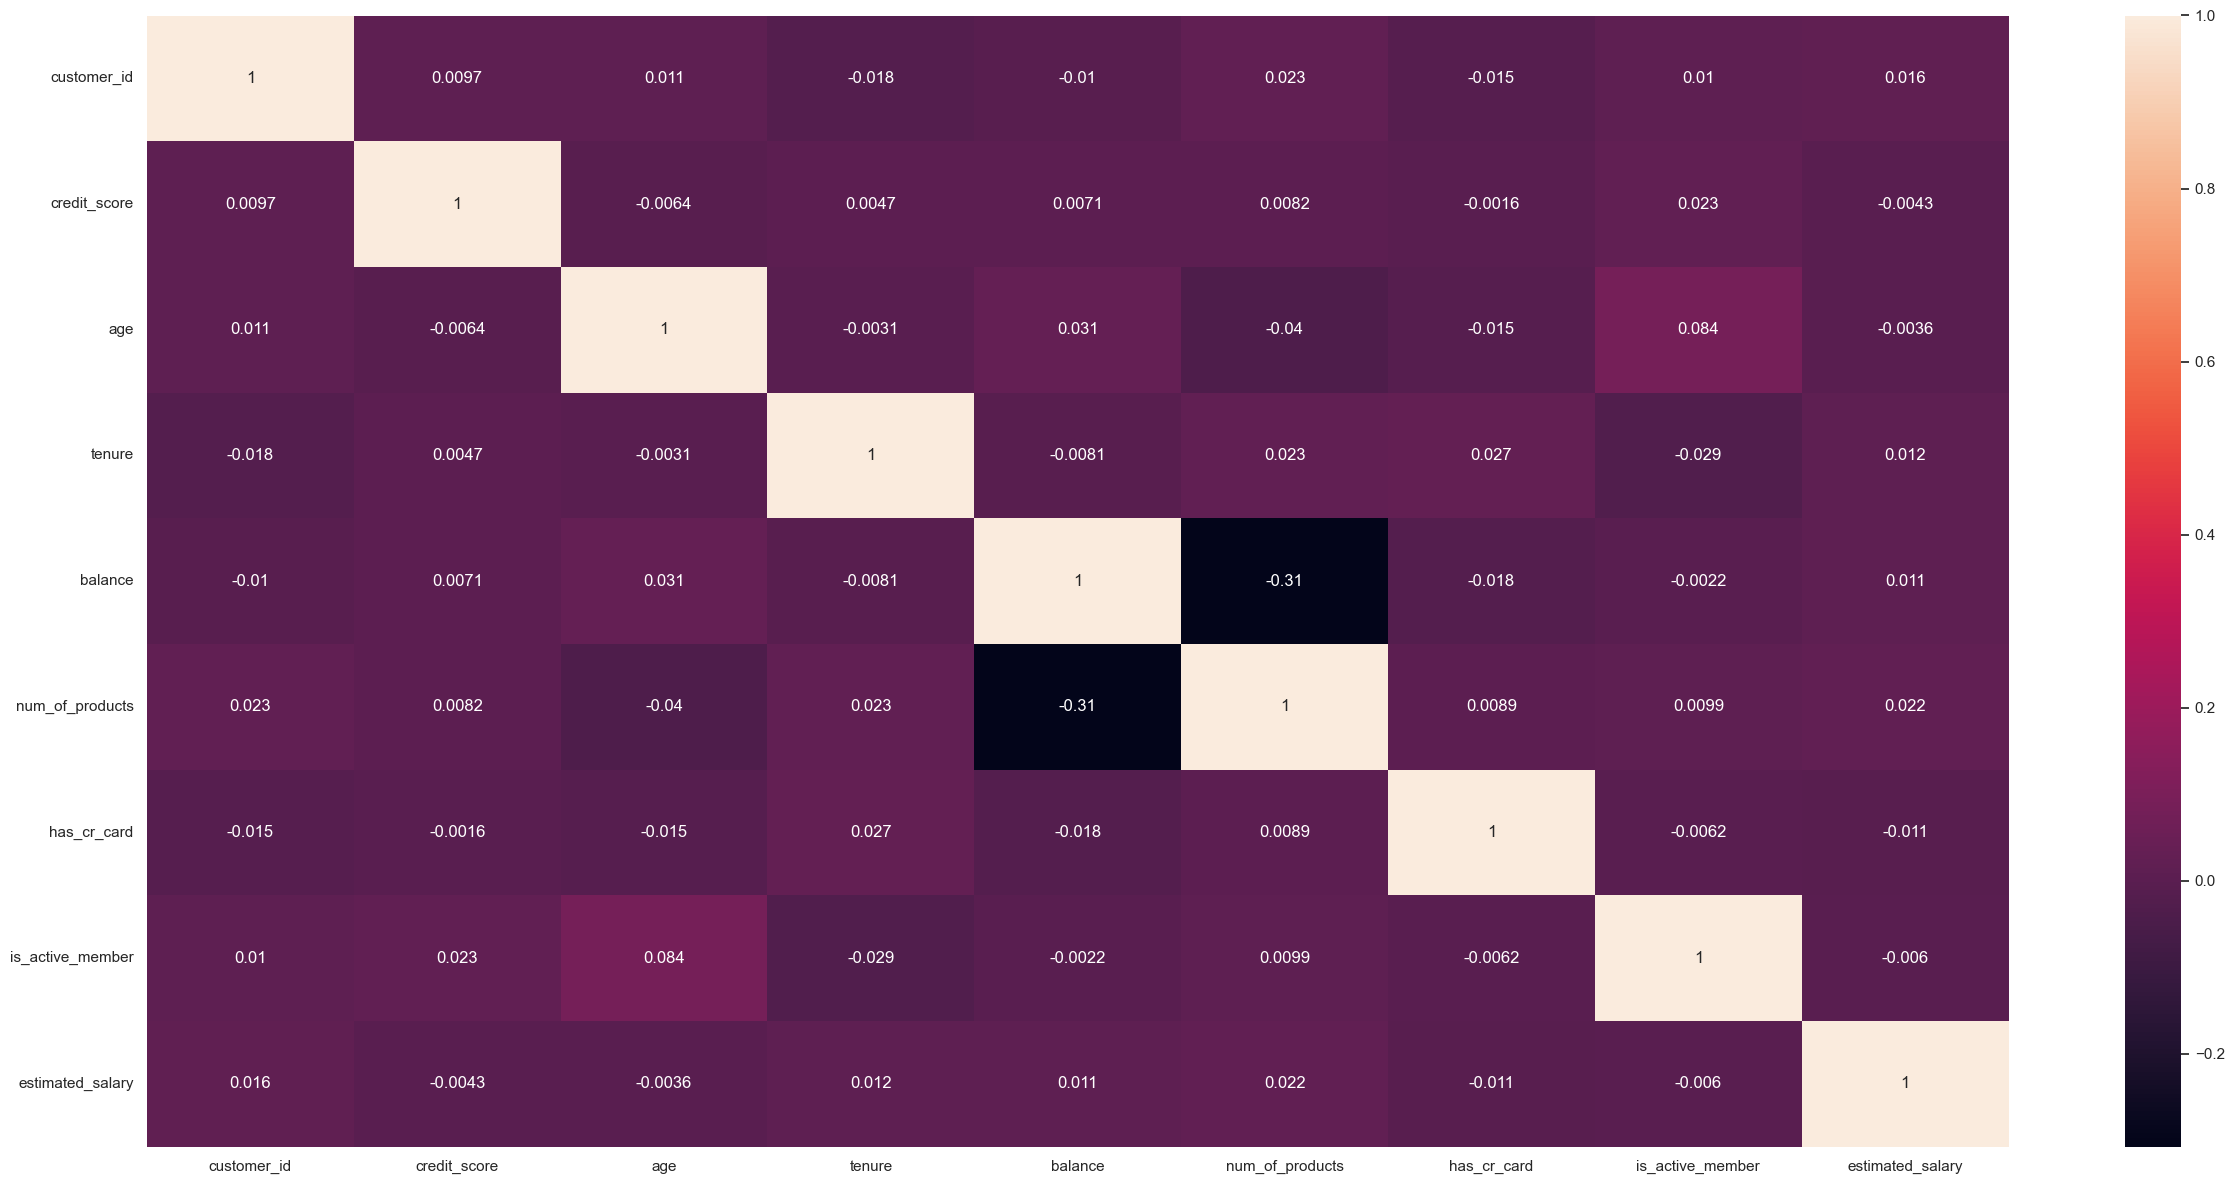

In [251]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);
save_fig('heatmap_multivariate_correlation')

There are no significant linear correlation between the features.

### 4.3.2. Categorical Features

In [51]:
df4.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,credit_score_category,estimated_monthly_salary,products_used_year
2151,753,France,Male,57,7,0.00,1,1,0,159475.08,1,5,13289.59,0.14
8392,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1,4,5331.78,0.33
5006,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0,5,9783.02,2.00
4117,561,France,Male,37,5,0.00,2,1,0,83093.25,0,2,6924.44,0.40
7182,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0,4,8956.08,0.33


Saving figure heatmap_multivariate_categoriacal


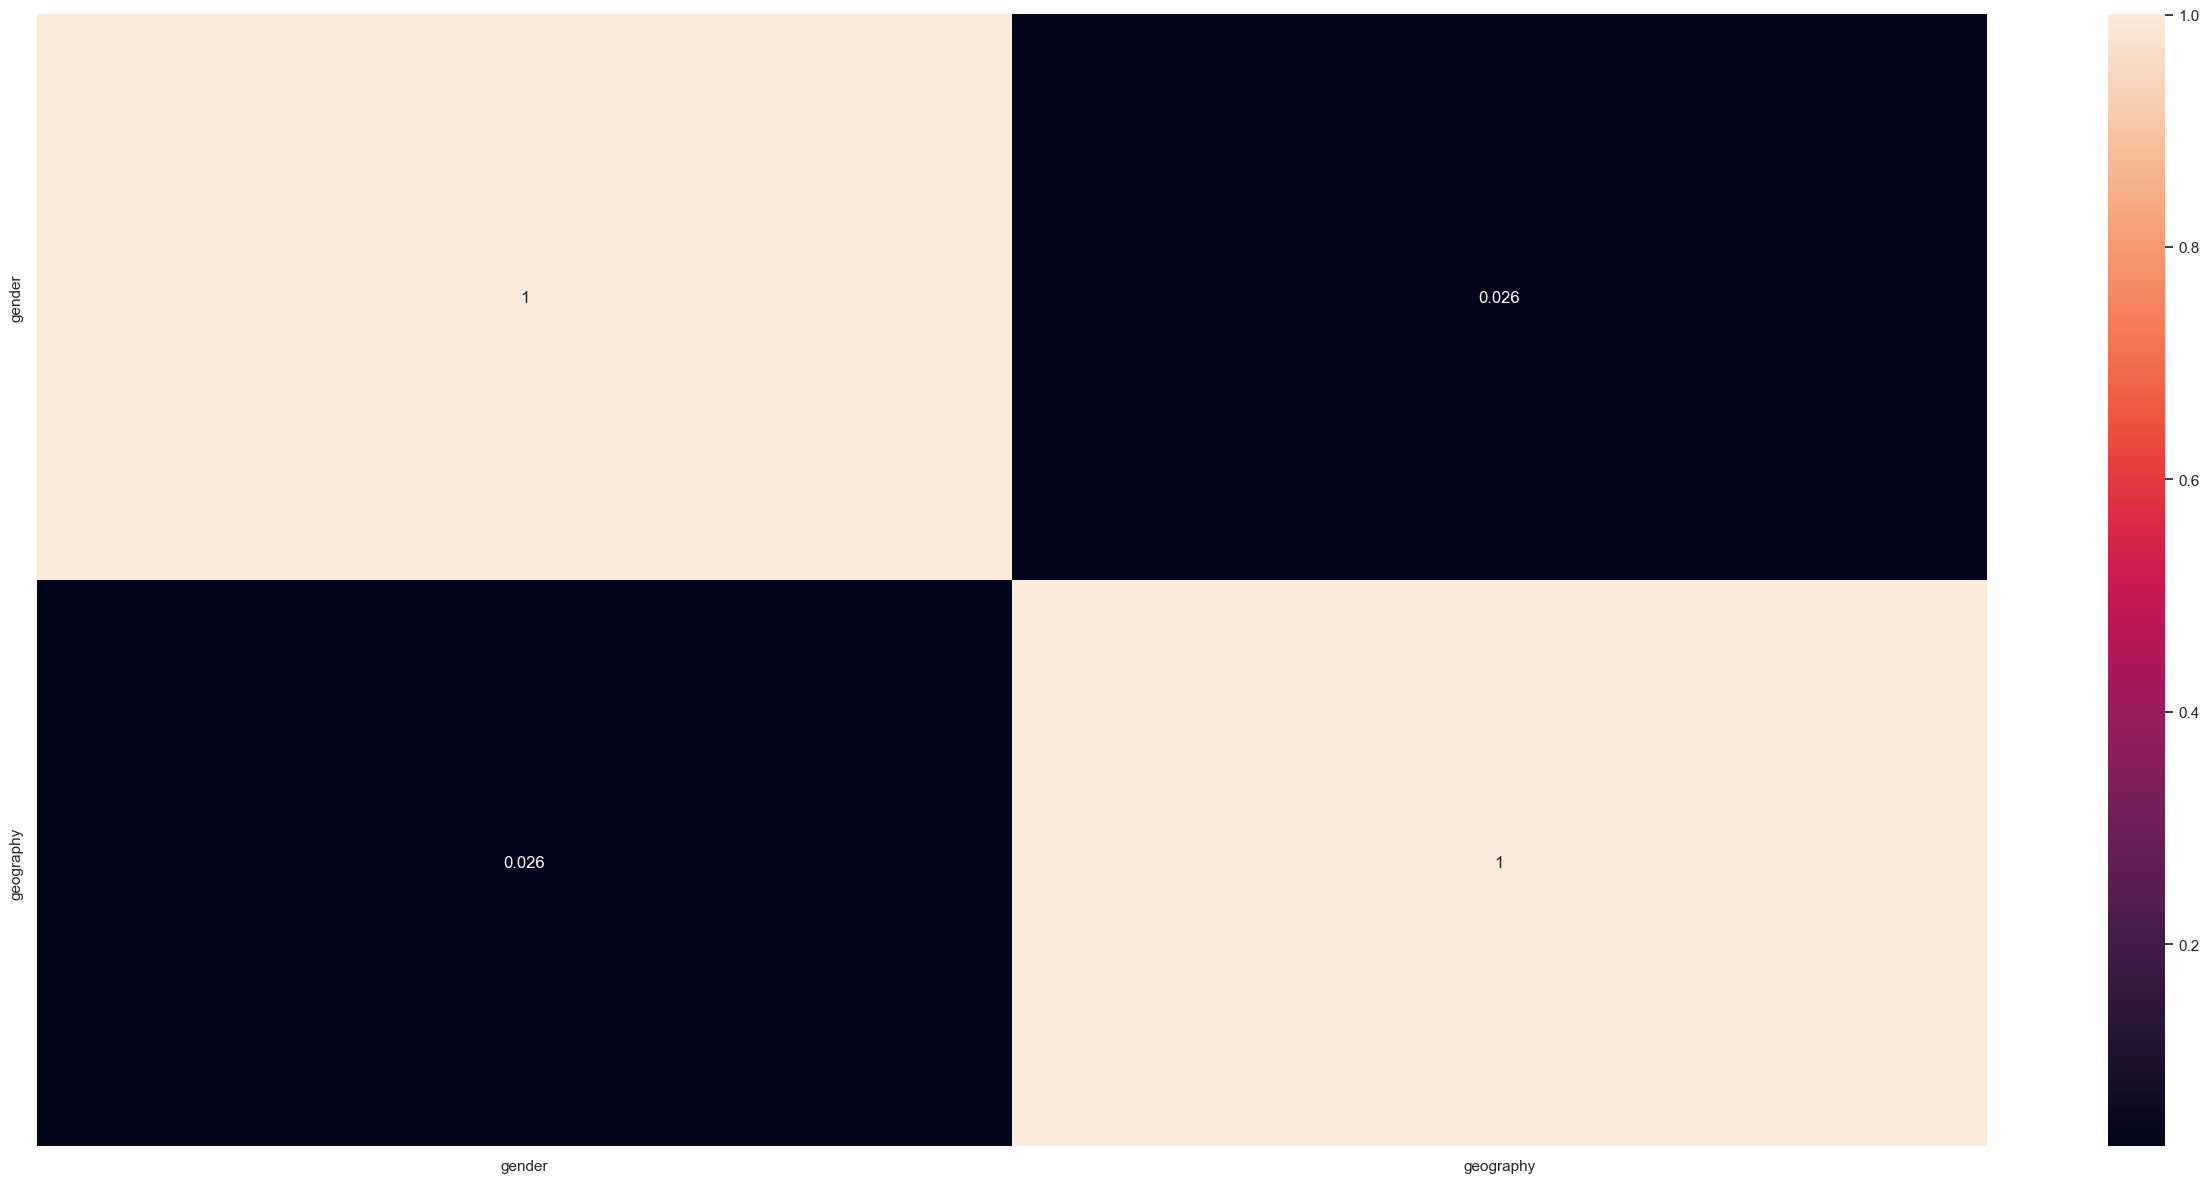

In [250]:
# Selecionando somente Dados Categóricos
cat = df4.loc[:, ['gender', 'geography']]

# Calcula Cramer V
a1 = cramer_v(cat['gender'], cat['gender'])
a2 = cramer_v(cat['gender'], cat['geography'])

a3 = cramer_v(cat['geography'], cat['gender'])
a4 = cramer_v(cat['geography'], cat['geography'])

# Dataset Final
df = pd.DataFrame({
    'gender': [a1, a2],
    'geography': [a3, a4],
})

df = df.set_index(df.columns)

# Mapa de Calor para verificar a correlação entre as variáveis categóricas
sns.heatmap(df, annot=True);
save_fig('heatmap_multivariate_categoriacal')

As the numerical features, the categorical features has no significant linear correlation

# 5.0. Data Preparation

In [53]:
df5 = df4.copy()

## 5.1. Normalization

### 5.1.1. Rescaling

In [54]:
# Select only the numerical columns names without the target feature
NUMERICAL = df5.select_dtypes(include=['int64', 'float64']).drop('exited', axis=1).columns

# Create pipeline to apply StandrdScaler to the numerical features.
numerical_pipe = Pipeline([
    ('scaler', StandardScaler())
])

## 5.2. Transformations

### 5.2.1. Encodings

In [55]:
# Select only the categorical columns names
CATEGORICAL = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns

# Create pipeline to apply OneHotEncoder to the categorical features.
categorical_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse=False))
])

Categorical features: Index(['geography', 'gender'], dtype='object')


## 5.4. Preprocessing Pipeline

In [56]:
# Create the DataPreparation Transformer to apply the 
# Encoders and Transformations to the features
data_preparation = ColumnTransformer(
    transformers=[
        ('num', numerical_pipe, NUMERICAL),
        ('cat', categorical_pipe, CATEGORICAL),
    ]
)

# 6.0. Feature Selection

In [144]:
df6 = df5.copy()

## 6.1. Random Forest Feature Importance

Saving figure rf_feature_importance


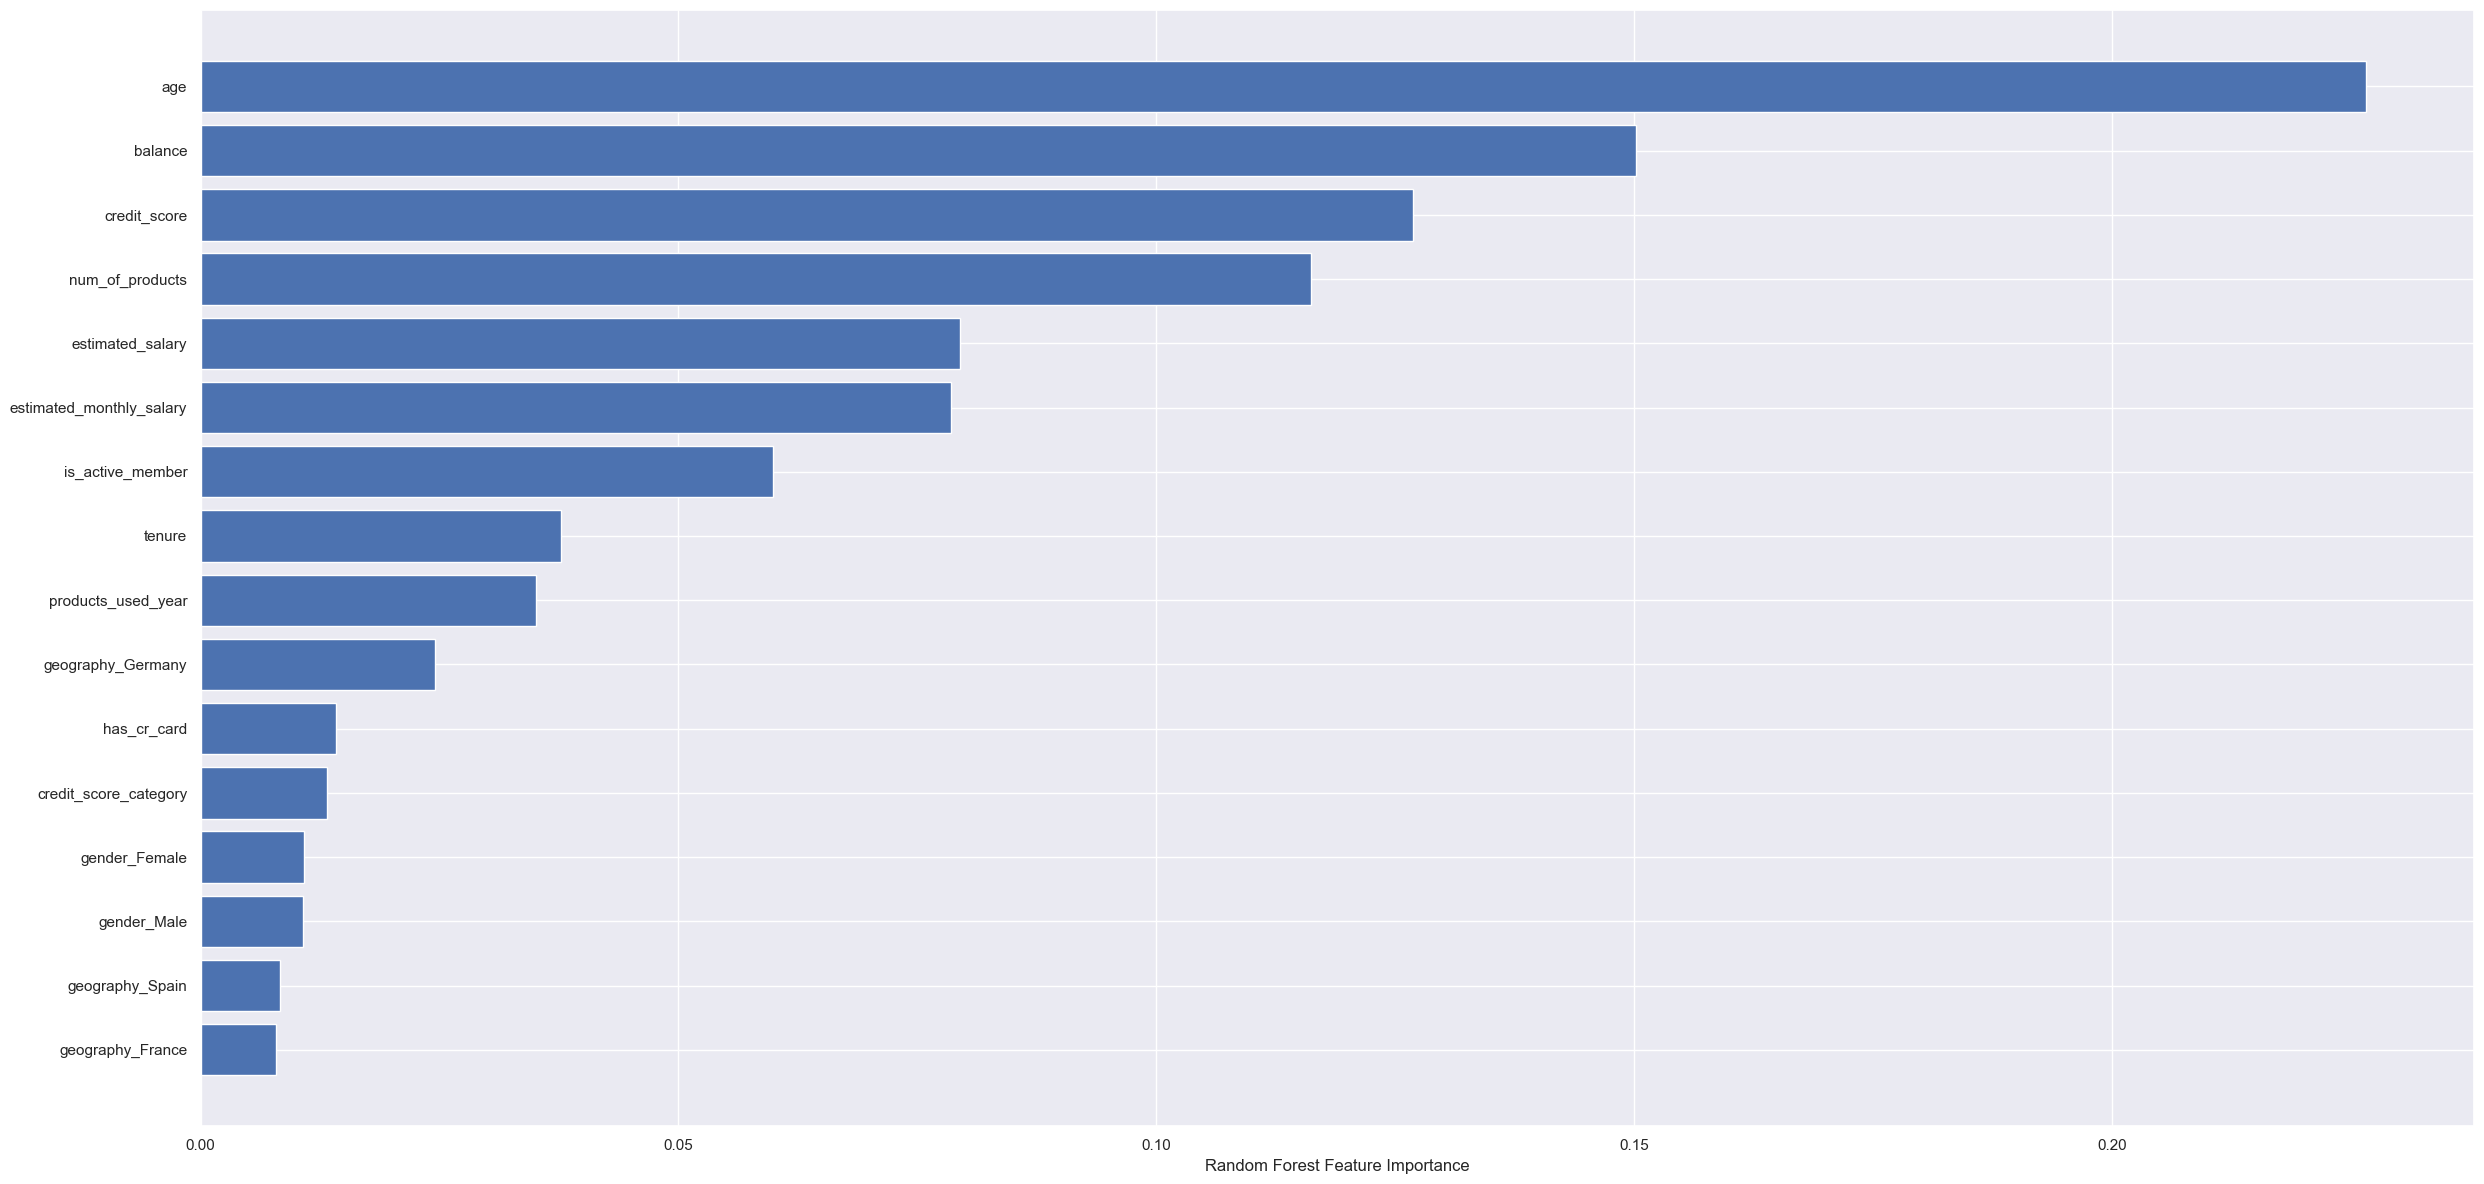

In [252]:
# Define Scaler and Random Forest Regressor
ss = StandardScaler()
rf = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)

# Apply Scaler and Pre Processing to Dataframe
df6_num = pd.DataFrame(ss.fit_transform(df6[NUMERICAL].copy()), columns=NUMERICAL)
df6_cat = pd.get_dummies(df6.loc[:, CATEGORICAL].copy()).reset_index(drop=True)
df6_scaled = pd.concat([df6_cat, df6_num], axis=1)

# Train Random Fores Regressor
rf.fit(df6_scaled.copy(), df6.loc[:, 'exited'].copy())

# Display cols_selected_boruta by Random Forest Regressor ≈
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df6_scaled.iloc[:, sorted_idx].columns, rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");
save_fig('rf_feature_importance')

# 7.0. Machine Learning Model Selection

In [58]:
df7 = df6.copy()

## 7.1. Models and Hyperparameters Definitions

In [59]:
# Create the Models and parameters to test in order to find 
# the best Model and parameters using the GridSearchCV
param_grid = [
    {
        'preprocessing': [data_preparation],
        'classifier': [SVC(random_state=SEED)], 
        'classifier__gamma': np.linspace(0.001, 100, 15, True),
        'classifier__C': np.linspace(0.001, 100, 10, True),
    },
    {
        'preprocessing': [data_preparation], 
        'classifier': [LogisticRegression(n_jobs=10, random_state=SEED)],
        'classifier__C': np.linspace(0.001, 100, 15, True),
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__solver' : ['saga'],
        'classifier__max_iter' : [1000],
    },
    {
        'preprocessing': [data_preparation], 
        'classifier': [RandomForestClassifier(n_jobs=-1, random_state=SEED)],
        'classifier__n_estimators': list(range(100, 501, 50)),
        'classifier__max_features': [2, 3, 4],
        'classifier__max_depth': list(range(3, 11)) ,
    },
    {
        'preprocessing': [data_preparation], 
        'classifier': [XGBClassifier(n_jobs=-1, random_state=SEED)],
        'classifier__n_estimators': list(range(100, 501, 50)),
        'classifier__max_depth': list(range(3, 11)),
    }
]

## 7.2. Data Split

In [60]:
# Split train and test data to use in the Grid SearchCV
X_t = df7.drop(['exited'], axis = 1)
y_t = df7.loc[:, 'exited']

## 7.3. Grid Search to Find the Best Model and Hyperparameter

In [61]:
# Create the Pipeline that will be used to train, test and determine
# the best model and parameters.
pipe = Pipeline(
    [
        ('preprocessing', data_preparation), 
        ('classifier', RandomForestClassifier(n_jobs=-1, random_state=SEED))
    ],
)

# Create GridSearchCV Object that will use the Pipeline to find
# the best model and parameters
grid = GridSearchCV(pipe, param_grid, cv=10, error_score='raise', scoring='roc_auc')
grid.fit(X_t, y_t)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'credit_score_category', 'estimated_monthly_salary',
       'products_used_...
                                                                             Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'credit_score_category', 'estimated_monthly_salary',
       'products_used_year'],
      dtype='object')),
                                                                            ('cat',
                                                                             Pipeline(steps=[('encoder',
                                                                                              OneHotEncoder(drop='first',
                                                                                                            sparse=False))]),
                                                                             Index(['geography', 'gender'], dtype='object'))])]}],
             scoring='roc_auc')

In [62]:
# Save the results obtained in the GridSearchCV execution
results = pd.DataFrame(grid.cv_results_)
results.to_csv('../data/exports/training_results.csv', index=False)

# Displays GridSearchCV results
print(f"Best params:\n{grid.best_estimator_[1]}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")
print(f"Best cross-validation score: {grid.scorer_}\n")

Best params:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42, ...)

Best cross-validation score: 0.86

Best cross-validation score: make_scorer(roc_auc_score, needs_threshold=True)



## 7.4. Train Choosen Model Using Best Parameters

In [63]:
# Create Model with Best Estimator and Features
model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    n_jobs=-1,  
    random_state=SEED,
    eval_metric='auc'
)

# Create Training Pipeline
train_pipe = Pipeline([
    # Rename Columns
    ('rename_columns', rename_pipe),
    
    # Feature engineering
    ('create_credit_score', utils.CreditScoreCategoryFeature()),
    ('create_estimated_salary', utils.EstimatedMonthlySalaryFeature()),
    ('create_products_used', utils.ProductsUsedByYearFeature()),
    
    # Columns Filtering
    ('filter_columns', utils.FilterColumns(columns=['customer_id', 'surname', 'row_number'])),
    
    # Data Preparation
    ('data_preparation', data_preparation), 
    
    # Model Training
    ('train_classifier', model)
])

# Fit Training Pipeline
model_trained = train_pipe.fit(X_train, y_train)
model_trained

Pipeline(steps=[('rename_columns',
                 Pipeline(steps=[('rename', RenameDataframeColumns())])),
                ('create_credit_score', CreditScoreCategoryFeature()),
                ('create_estimated_salary', EstimatedMonthlySalaryFeature()),
                ('create_products_used', ProductsUsedByYearFeature()),
                ('filter_columns',
                 FilterColumns(columns=['customer_id', 'surname',
                                        'row_number'])),
                ('data_prepara...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=3, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

In [64]:
print(f'AUC score on Train Data: {model_trained.score(X_train, y_train):.3f}')

AUC score on Train Data: 0.884


## 7.5. Evaluate Trained Model

In [65]:
# Rename test dataframe columns
X_t = rename_pipe.fit_transform(X_test)

y_predicted = model_trained.predict_proba(X_t)[:, 1]

print(f'AUC score on Teste Data: {roc_auc_score(y_test, y_predicted):.3f}')

AUC score on Teste Data: 0.861


## 7.6. Retrain Model With All Data

In [66]:
# Split train and test data using all data available to train
# the selected model
X_t = df_raw.drop('Exited', axis=1)
y_t = df_raw.loc[:, 'Exited']

# Create Model with Best Estimator and Features
model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    n_jobs=-1,  
    random_state=SEED,
    eval_metric='auc'
)

# Create Training Pipeline
train_pipe = Pipeline([
    # Rename Columns
    ('rename_columns', rename_pipe),
    
    # Feature engineering
    ('create_credit_score', utils.CreditScoreCategoryFeature()),
    ('create_estimated_salary', utils.EstimatedMonthlySalaryFeature()),
    ('create_products_used', utils.ProductsUsedByYearFeature()),
    
    # Columns Filtering
    ('filter_columns', utils.FilterColumns(columns=['customer_id', 'surname', 'row_number'])),
    
    # Data Preparation
    ('data_preparation', data_preparation), 
    
    # Model Training
    ('train_classifier', model)
])

# Fit Training Pipeline
model_trained = train_pipe.fit(X_t, y_t)
model_trained

Pipeline(steps=[('rename_columns',
                 Pipeline(steps=[('rename', RenameDataframeColumns())])),
                ('create_credit_score', CreditScoreCategoryFeature()),
                ('create_estimated_salary', EstimatedMonthlySalaryFeature()),
                ('create_products_used', ProductsUsedByYearFeature()),
                ('filter_columns',
                 FilterColumns(columns=['customer_id', 'surname',
                                        'row_number'])),
                ('data_prepara...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=3, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

In [67]:
print(f'Model with All Data Score: {model_trained.score(X_t, y_t)}')

Model with All Data Score: 0.8857


## 7.7. Saving Pipeline on Disk

In [68]:
# Save pipeline to disk in pickle format
joblib.dump(model_trained, '../models/pipeline.pkl', compress = 1)

['../models/pipeline.pkl']

# 8.0. Predict Churn

## 8.1. Load Model

In [69]:
pipeline = joblib.load('../models/pipeline.pkl')
pipeline

Pipeline(steps=[('rename_columns',
                 Pipeline(steps=[('rename', RenameDataframeColumns())])),
                ('create_credit_score', CreditScoreCategoryFeature()),
                ('create_estimated_salary', EstimatedMonthlySalaryFeature()),
                ('create_products_used', ProductsUsedByYearFeature()),
                ('filter_columns',
                 FilterColumns(columns=['customer_id', 'surname',
                                        'row_number'])),
                ('data_prepara...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=3, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

## 8.2. Load Data

In [70]:
df_raw = pd.read_csv('../data/test/abandono_teste.csv', delimiter=';')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15


## 8.3. Predict Churn

In [71]:
df_raw['Exited'] = pipeline.predict(df_raw)
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08,0
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90,0
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67,0
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10,0
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15,0


In [72]:
# Save on disk calculated result using trained model
date = datetime.now().date().strftime("%Y%m%d")

df_raw.loc[:, ['RowNumber', 'Exited']].to_csv(f'../data/answer/abandonos_{date}.csv', index = False)